# Análise de dados da base Titanic

Pré requisitos para importar o dataset do Kaggle:

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

Download do dataset:

In [5]:
! kaggle competitions download titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 24.5MB/s]


In [6]:
! unzip titanic

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Bibliotecas utilizadas:

In [7]:
# ! pip install -U scipy
# ! pip install -U spacy

In [ ]:
! pip install --pre pycaret

In [9]:
from pycaret.utils import version
version()

'3.0.0.rc6'

In [ ]:
! pip install mlflow

In [11]:
# ! pip install -U matplotlib 

In [12]:
# ! pip install -U scikit-learn==0.24

In [247]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import graphviz

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.tree import export_graphviz

from scipy.stats import t
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp

# Funções Utilizadas:

In [14]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(12,9))
    plt.xticks(rotation=90)
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

In [15]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )

In [16]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [17]:
def biv_discreta(var, df):
    df['Died'] = 1-df.Survived
    df[var] = df[var].astype(str)
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_Died': g['Died'].sum(),
                        'qt_Survived': g['Survived'].sum(),
                        'Survived':g['Survived'].mean(), 
                        var: g['Survived'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.Survived*(1-biv.Survived)/biv.cont)**.5
    biv['Survived_sup'] = biv.Survived+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['Survived_inf'] = biv.Survived+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.Survived/(1-biv.Survived))
    biv['logit_sup'] = np.log(biv.Survived_sup/(1-biv.Survived_sup))
    biv['logit_inf'] = np.log(biv.Survived_inf/(1-biv.Survived_inf))

    tx_Survived_geral = df.Survived.mean()
    woe_geral = np.log(df.Survived.mean() / (1 - df.Survived.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(3,1, figsize=(15,20))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=20)
    
    sns.countplot(data=df, x=var, palette='mako', ax=ax[1])
    ax[1].set_title('Count values da variável: ' + var)
    ax[1].bar_label(ax[1].containers[0])
    ax[1].tick_params(axis='x', rotation=20)

    sns.countplot(data=df, x=var, palette='mako', hue='Survived', ax=ax[2])
    ax[2].set_title('Count values da variável: ' + var + ' separados por Survived')
    ax[2].bar_label(ax[2].containers[0])
    ax[2].bar_label(ax[2].containers[1])
    ax[2].tick_params(axis='x', rotation=20)
    return biv

In [18]:
def biv_continua(var, ncat, df):
    df['Died'] = 1-df.Survived
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_Died': g['Died'].sum(),
                        'qt_Survived': g['Survived'].sum(),
                        'Survived':g['Survived'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.Survived*(1-biv.Survived)/biv.cont)**.5
    biv['Survived_sup'] = biv.Survived+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['Survived_inf'] = biv.Survived+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.Survived/(1-biv.Survived))
    biv['logit_sup'] = np.log(biv.Survived_sup/(1-biv.Survived_sup))
    biv['logit_inf'] = np.log(biv.Survived_inf/(1-biv.Survived_inf))

    tx_Survived_geral = df.Survived.mean()
    woe_geral = np.log(df.Survived.mean() / (1 - df.Survived.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(3,1, figsize=(15,20))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    

    sns.countplot(data=df, x=cat_srs, palette='mako', ax=ax[1])
    ax[1].set_title('Count values da variável: ' + var)
    ax[1].bar_label(ax[1].containers[0])
    ax[1].tick_params(axis='x', rotation=20)

    sns.countplot(data=df, x=cat_srs, palette='mako', hue='Survived', ax=ax[2])
    ax[2].set_title('Count values da variável: ' + var + ' separados por Survived')
    ax[2].bar_label(ax[2].containers[0])
    ax[2].bar_label(ax[2].containers[1])
    ax[2].tick_params(axis='x', rotation=20)
    return None

# Análise Geral:

Vamos analisar no geral o que possuimos nas tabelas de dados:

In [19]:
df_train = pd.read_csv('train.csv')
df_age=pd.DataFrame()
df_age[['PassengerId', 'Age_Raw']] = df_train[['PassengerId', 'Age']]
df_test = pd.read_csv('test.csv')
df_gs = pd.read_csv('gender_submission.csv')

**Descrição do que as variáveis representam:** <br>
*Survived*: Indica se o passageiro sobreviveu. (0 = Não, 1 = Sim) <br>
*Pclass*: Classe do passageiro. (1 = Primeira, 2 = Segunda, 3 = Terceira) <br>
*Sex*: Sexo do passageiro. <br>
*Age*: Idade em anos. <br>
*SibSp*: Número de irmãos/cônjuges a bordo do Titanic. <br>
*Parch*: Número de pais/filhos a bordo do Titanic. <br>
*Ticket*: Número do bilhete. <br>
*Fare*: Tarifa de passageiro. <br>
*Cabin*: Número da cabine. <br>
*Embarked*: Porto de embarcação. (C = Cherbourg, Q = Queenstown, S = Southampton)


In [20]:
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [22]:
df_train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [23]:
df_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [25]:
df_gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [26]:
df_gs.head(2)

,PassengerId,Survived
0,892,0
1,893,1


In [27]:
data_unseen = df_test.merge(df_gs)

In [28]:
data_unseen.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1


In [29]:
#df para utilizarmos na regressão para previsão de idade
df = pd.concat([df_train, data_unseen])
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)

# Verificação de Dados Duplicados:

In [30]:
df_train.duplicated().value_counts()

False    891
dtype: int64

In [31]:
data_unseen.duplicated().value_counts()

False    418
dtype: int64

<font color='darkblue'>Concluimos que não possuímos linhas duplicadas nas nossas bases de dados.</font>

# Análise de Dados Missing:

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


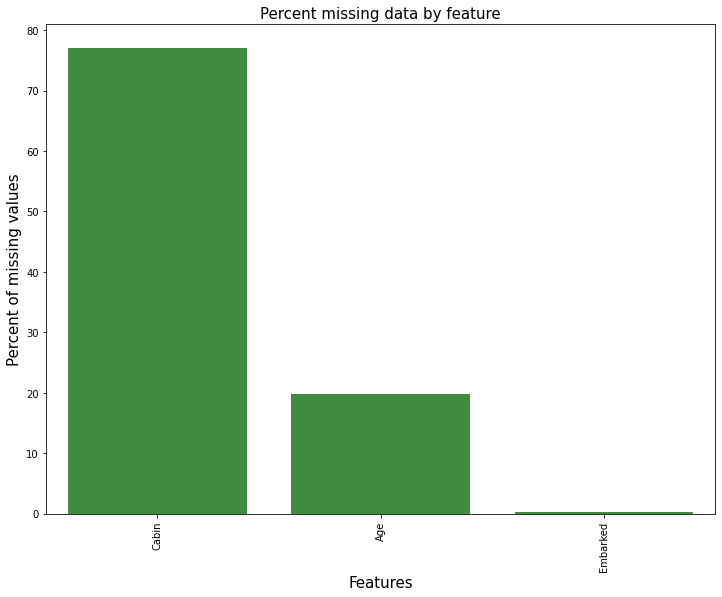

In [32]:
missingdata(df_train)

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


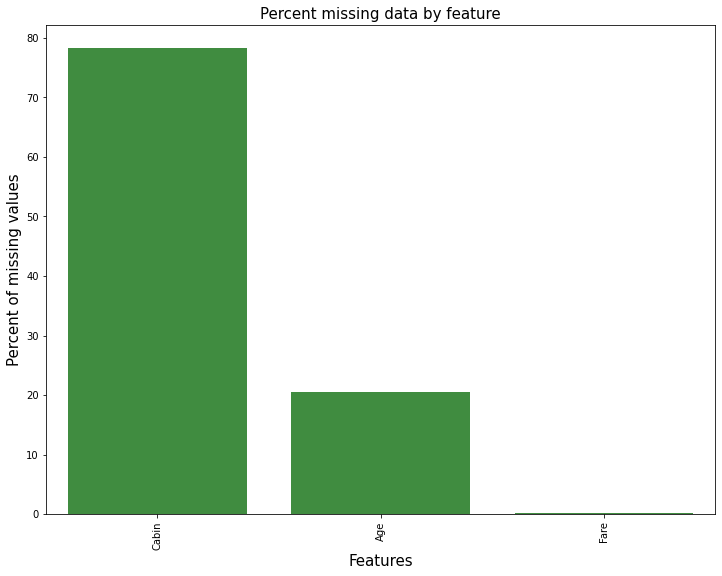

In [33]:
missingdata(data_unseen)

<font color='darkblue'>Já observamos que a coluna *Age* possui alguns valores missing, devemos escolher como tratar esses dados. (Excluir dados missing? Substituir pela média?). A coluna *Cabin* possui poucos valores preenchidos, iremos tratar essa lacuna mais para frente. Talvez também poderemos excluir colunas como: *PassengerId*, *Name* e *Ticket* de uma futura modelagem, mas analisaremos com mais calma antes de tomar alguma conclusão.</font>

# Análise Descritiva:

Antes de tomarmos alguma decisão sobre as variáveis vamos realizar uma análise descritiva mais geral para entendermos nossos dados.

## *Survived*

Nossa variável resposta.

Tipo:

In [34]:
df_train['Survived'].dtypes

dtype('int64')

Distribuição:

[Text(0, 0, '549'), Text(0, 0, '342')]

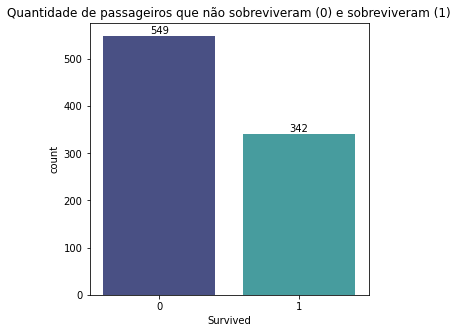

In [35]:
fig, ax = plt.subplots(figsize=(5,5))

sns.countplot(data=df_train, x='Survived', palette='mako', ax=ax)
ax.set_title('Quantidade de passageiros que não sobreviveram (0) e sobreviveram (1)')
ax.bar_label(ax.containers[0])

Porcentagem dos valores:

In [36]:
ctb = (pd.crosstab(index = df_train['Survived'], columns = df_train['Survived'],
                  normalize=True, margins = True, margins_name= "Total")).mul(100).round(2).astype(str)+'%'
ctb['Total']

Survived
0        61.62%
1        38.38%
Total    100.0%
Name: Total, dtype: object

<font color='darkblue'>Temos a variável resposta como *Int*, talvez podemos considerar utilizar o tipo *Bool* para modelagem.<br> No geral a maioria dos passageiros não sobreviveu (61.62%), já temos essa conclusão.</font>

##*PassengerId*

Tipo:

In [37]:
df_train['PassengerId'].dtypes

dtype('int64')

Distribuição:

<AxesSubplot: xlabel='PassengerId', ylabel='count'>

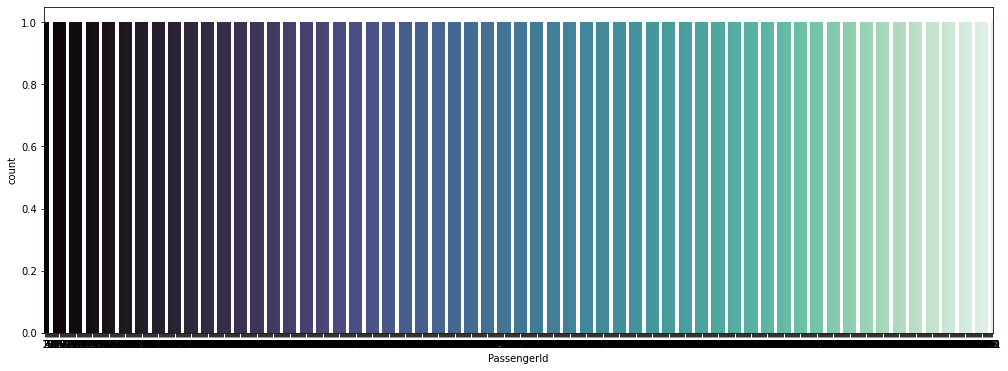

In [38]:
fig, ax = plt.subplots(figsize=(17,6))

sns.countplot(data=df_train, x='PassengerId', palette='mako', ax=ax)

Verificar valores mínimos e máximos:

In [39]:
df_train['PassengerId'].min()

1

In [40]:
df_train['PassengerId'].max()

891

<font color='darkblue'>Concluimos que esta coluna está aqui apenas para uma identificação geral, praticamente um indice, 891 valores indo de 1 a 891. Não recomendado utilizar para a modelagem.</font>

##*Pclass*

Primeira, segunda ou terceira classe que o passageiro é classificado.

Tipo:

In [41]:
df_train['Pclass'].dtypes

dtype('int64')

Distribuição:

,qt_Died,qt_Survived,Survived,Pclass,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
Pclass,,,,,,,,,,,,,,
1,80,136,0.629630,1,216,0.032857,0.694394,0.564866,0.530628,0.820741,0.260933,1.003916,1.294029,0.734221
2,97,87,0.472826,2,184,0.036806,0.545445,0.400207,-0.108803,0.182282,-0.404601,0.364485,0.655570,0.068687
3,372,119,0.242363,3,491,0.019338,0.280359,0.204366,-1.139770,-0.942681,-1.359227,-0.666483,-0.469393,-0.885940


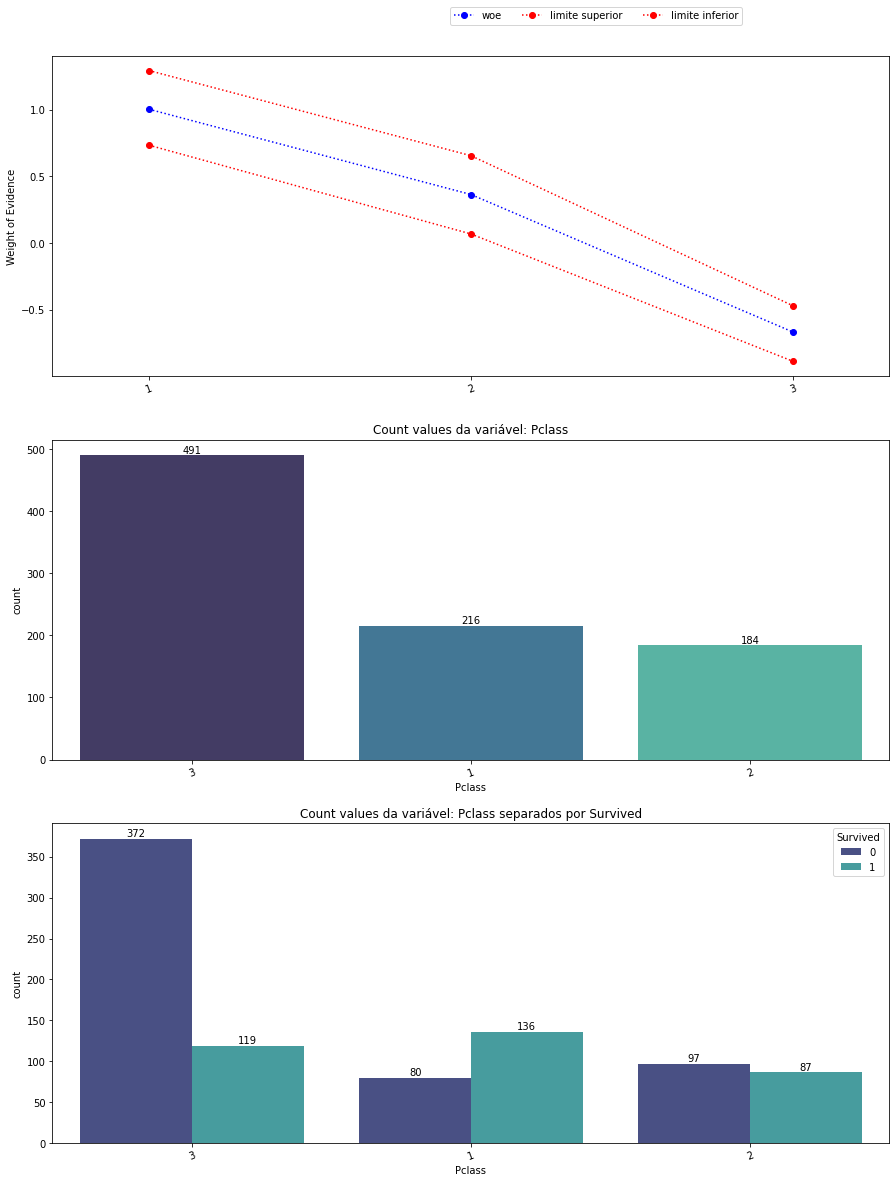

In [42]:
biv_discreta(var = 'Pclass', df = df_train)

Porcentagem dos valores:

In [43]:
ctb =( pd.crosstab(index = df_train['Pclass'], columns = df_train['Pclass'],
                  normalize=True, margins = True, margins_name= "Total")).mul(100).round(2).astype(str)+'%'
ctb['Total']

Pclass
1        24.24%
2        20.65%
3        55.11%
Total    100.0%
Name: Total, dtype: object

Porcentagem de sobreviventes em cada grupo:

In [44]:
ctb = (pd.crosstab(index = df_train['Pclass'], columns = df_train['Survived'],
                  normalize='index', margins = True, margins_name= "Total")).mul(100).round(2).astype(str)+'%'
ctb

Survived,0,1
Pclass,,
1,37.04%,62.96%
2,52.72%,47.28%
3,75.76%,24.24%
Total,61.62%,38.38%


<font color='darkblue'>Conseguimos obter algumas informações interessantes, a maioria dos passageiros pertenciam a terceira classe (55.11%). A maioria das pessoas da primeira classe sobreviveu (62.96%) e a maioria das pessoas da terceira classe não sobreviveu (75.76%). O gráfico de WOE indica que possivelmente esta veriável seja útil para o modelo em uma primeira impressão, mas vale alterar o tipo da variável para categórico.</font>

##Name

Tipo:

In [45]:
df_train['Name'].dtypes

dtype('O')

Distribuição:

<AxesSubplot: xlabel='Name', ylabel='count'>

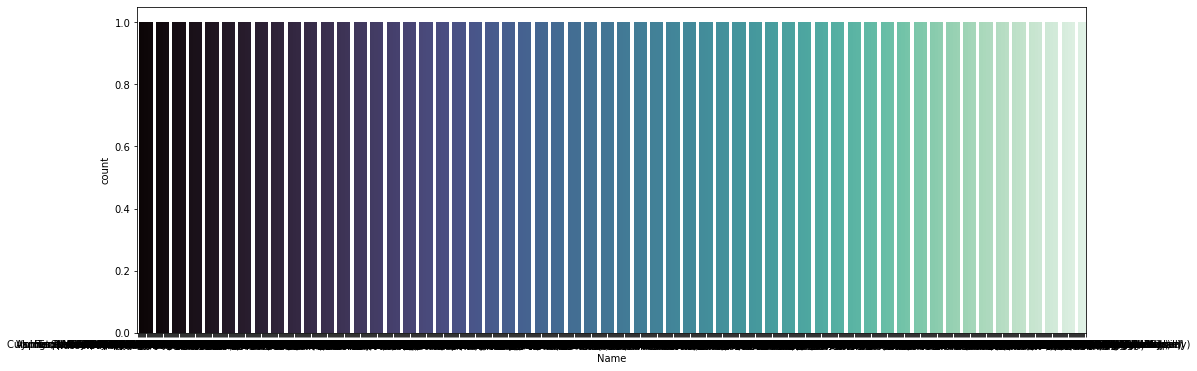

In [46]:
fig, ax = plt.subplots(figsize=(17,6))

sns.countplot(data=df_train, x='Name', palette='mako', ax=ax)

Alguns valores desta coluna:

In [47]:
df_train['Name'].sample(n = 30)

654                         Hegarty, Miss. Hanora "Nora"
65                              Moubarek, Master. Gerios
885                 Rice, Mrs. William (Margaret Norton)
421                                  Charters, Mr. David
56                                     Rugg, Miss. Emily
91                            Andreasson, Mr. Paul Edvin
38                    Vander Planke, Miss. Augusta Maria
414                            Sundman, Mr. Johan Julian
690                              Dick, Mr. Albert Adrian
523      Hippach, Mrs. Louis Albert (Ida Sophia Fischer)
265                                    Reeves, Mr. David
320                                   Dennis, Mr. Samuel
592                           Elsbury, Mr. William James
298                                Saalfeld, Mr. Adolphe
307    Penasco y Castellana, Mrs. Victor de Satode (M...
774                Hocking, Mrs. Elizabeth (Eliza Needs)
851                                  Svensson, Mr. Johan
198                     Madigan

<font color='darkblue'>Apesar desta coluna possuir todos os valores diferentes uns dos outros talvez conseguiremos criar alguns grupos com o pronome de tratamento de cada indivíduo.</font>

##Sex

Sexo do passageiro.

Tipo:

In [48]:
df_train['Sex'].dtypes

dtype('O')

Distribuição:

,qt_Died,qt_Survived,Survived,Sex,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
Sex,,,,,,,,,,,,,,
female,81,233,0.742038,female,314,0.024690,0.790618,0.693458,1.056589,1.328655,0.816337,1.529877,1.801943,1.289625
male,468,109,0.188908,male,577,0.016296,0.220914,0.156902,-1.457120,-1.260346,-1.681462,-0.983833,-0.787058,-1.208174


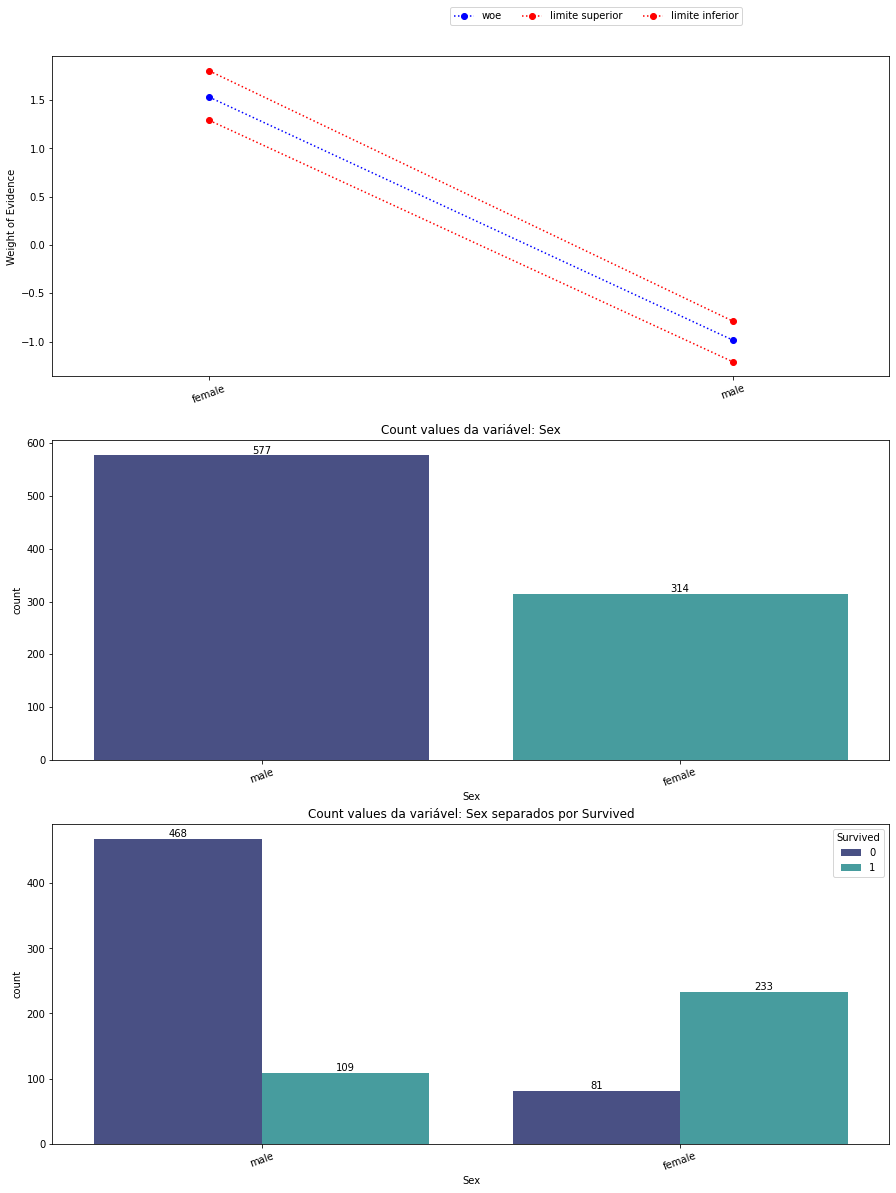

In [49]:
biv_discreta(var = 'Sex', df = df_train)

Porcentagem dos valores:

In [50]:
ctb =( pd.crosstab(index = df_train['Sex'], columns = df_train['Sex'],
                  normalize=True, margins = True, margins_name= "Total")).mul(100).round(2).astype(str)+'%'
ctb['Total']

Sex
female    35.24%
male      64.76%
Total     100.0%
Name: Total, dtype: object

Porcentagem de sobreviventes em cada grupo:

In [51]:
ctb = (pd.crosstab(index = df_train['Sex'], columns = df_train['Survived'],
                  normalize='index', margins = True, margins_name= "Total")).mul(100).round(2).astype(str)+'%'
ctb

Survived,0,1
Sex,,
female,25.8%,74.2%
male,81.11%,18.89%
Total,61.62%,38.38%


<font color='darkblue'>No geral, grande maioria dos passageiros eram do sexo masculino (64.76%). A maioria das mulheres sobreviveu (74.2%) e a maioria dos homens não sobreviveu (81.11%). Um WOE de mais de 1.5 e um de quase -1 parecem indicar que esta variável é uma excelente candidata para explicar nossa variável resposta.</font>

##Age

Idade dos passageiros.

Tipo:

In [52]:
df_train['Age'].dtypes

dtype('float64')

Distribuição:

Text(0.5, 1.0, 'Quantidade de passageiros por idade')

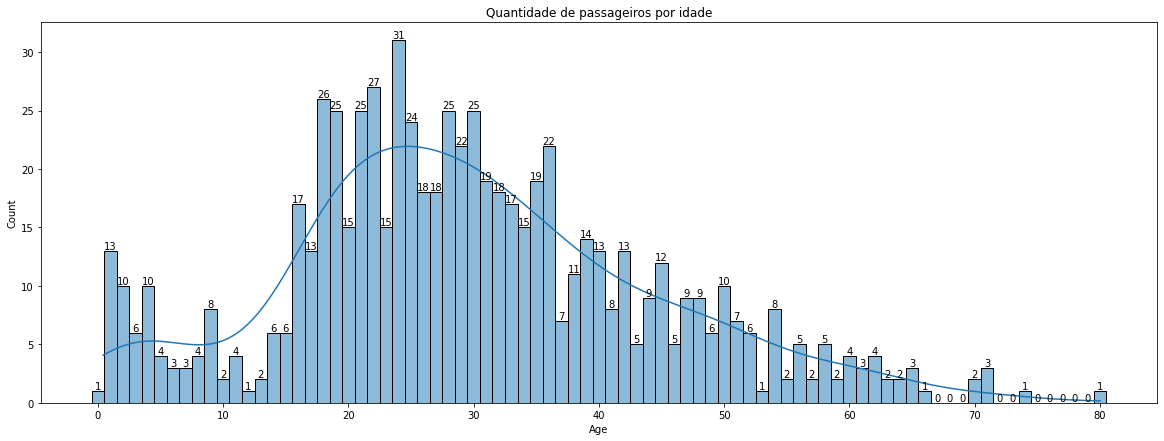

In [53]:
fig, ax = plt.subplots(figsize=(20,7))

sns.histplot(data=df_train, x='Age',discrete=True ,binrange=(0,80) ,kde=True, palette='mako', ax=ax)
ax.bar_label(ax.containers[0])
ax.set_title('Quantidade de passageiros por idade')

<AxesSubplot: ylabel='Age'>

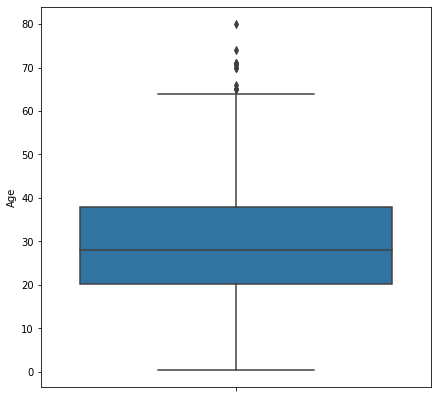

In [54]:
fig, ax = plt.subplots(figsize=(7,7))

sns.boxplot(y='Age', data=df_train, ax=ax)

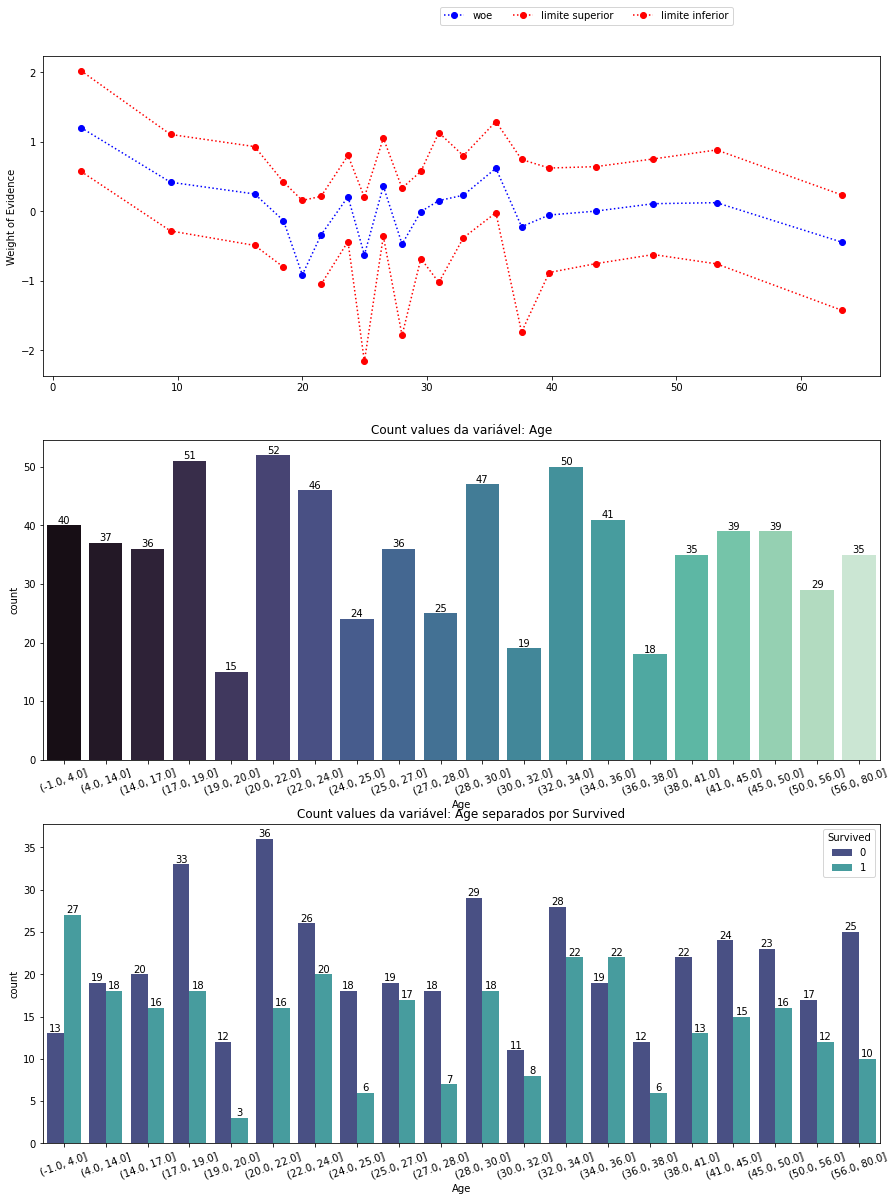

In [55]:
biv_continua(var = 'Age',ncat = 20, df = df_train)

Identificando máximos e mínimos:

In [56]:
df_train['Age'].nlargest(n=10)

630    80.0
851    74.0
96     71.0
493    71.0
116    70.5
672    70.0
745    70.0
33     66.0
54     65.0
280    65.0
Name: Age, dtype: float64

In [57]:
df_train['Age'].nsmallest(n=10)

803    0.42
755    0.67
469    0.75
644    0.75
78     0.83
831    0.83
305    0.92
164    1.00
172    1.00
183    1.00
Name: Age, dtype: float64

<font color='darkblue'>Apesar de alguns grupos possuirem um WOE aceitável a maioria dos grupos apresenta um WOE beirando o zero, talvez não seja uma variável explicativa muito eficiente para nosso modelo. É uma variável que não apresenta Outliers, e não temos valores negativos também.</font>

##SibSp

Número de irmãos/cônjuges a bordo.

Tipo:

In [58]:
df_train['SibSp'].dtypes

dtype('int64')

Distribuição tratando como dado discreto:

,qt_Died,qt_Survived,Survived,SibSp,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
SibSp,,,,,,,,,,,,,,
0,398,210,0.345395,0,608,0.019284,0.383266,0.307523,-0.639344,-0.475708,-0.811723,-0.166057,-0.002420,-0.338436
1,97,112,0.535885,1,209,0.034497,0.603893,0.467878,0.143788,0.421712,-0.128667,0.617076,0.895000,0.344621
2,15,13,0.464286,2,28,0.094250,0.657670,0.270901,-0.143101,0.652929,-0.990055,0.330187,1.126217,-0.516767
3,12,4,0.250000,3,16,0.108253,0.480736,0.019264,-1.098612,-0.077093,-3.930075,-0.625325,0.396194,-3.456787
4,15,3,0.166667,4,18,0.087841,0.351995,-0.018662,-1.609438,-0.610281,NaN,-1.136150,-0.136993,NaN
5,5,0,0.000000,5,5,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
8,7,0,0.000000,8,7,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf


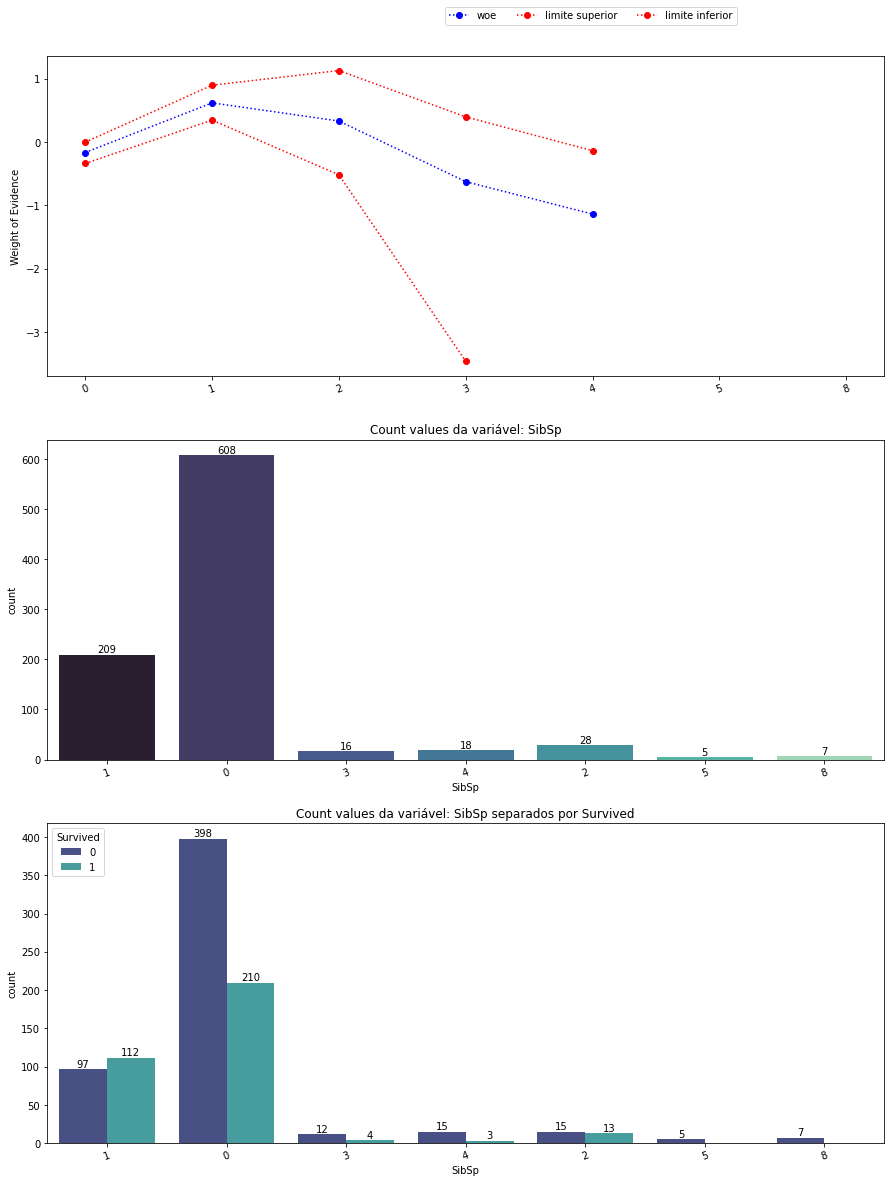

In [59]:
biv_discreta(var = 'SibSp', df = df_train)

<font color='darkblue'>Já observamos que a grande densidade de dados se encontra nos valores de 0 e 1. Talvez seja interessante criar 3 grupos com valores 0, 1 e igual e maiores que 2.</font>

##Parch

Número de pais/filhos a bordo.

Tipo:

In [60]:
df_train['Parch'].dtypes

dtype('int64')

Distribuição tratando como dado discreto:

,qt_Died,qt_Survived,Survived,Parch,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
Parch,,,,,,,,,,,,,,
0,445,233,0.343658,0,678,0.018240,0.379471,0.307845,-0.647036,-0.491796,-0.810214,-0.173748,-0.018508,-0.336926
1,53,65,0.550847,1,118,0.045790,0.641532,0.460163,0.204095,0.582021,-0.159688,0.677383,1.055309,0.313599
2,40,40,0.500000,2,80,0.055902,0.611270,0.388730,0.000000,0.452652,-0.452652,0.473288,0.925940,0.020636
3,2,3,0.600000,3,5,0.219089,1.208289,-0.008289,0.405465,NaN,NaN,0.878753,NaN,NaN
4,4,0,0.000000,4,4,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
5,4,1,0.200000,5,5,0.178885,0.696666,-0.296666,-1.386294,0.831470,NaN,-0.913007,1.304757,NaN
6,1,0,0.000000,6,1,0.000000,NaN,NaN,-inf,NaN,NaN,-inf,NaN,NaN


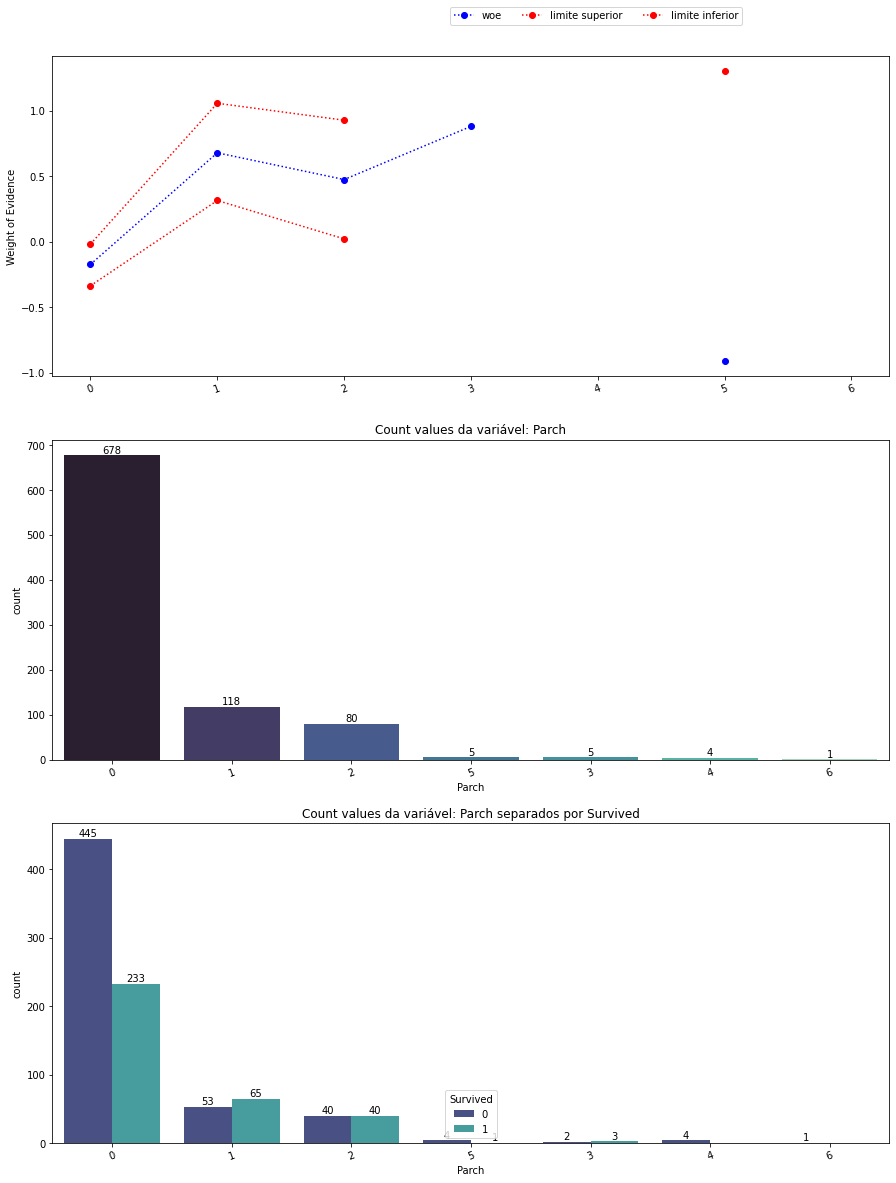

In [61]:
biv_discreta(var = 'Parch', df = df_train)

<font color='darkblue'>Já observamos que a grande densidade de dados se encontra no valor 0. Talvez seja interessante criar 4 grupos com valores 0, 1, 2 e igual e maiores que 3.</font>

##Ticket

Número do bilhete.

Tipo:

In [62]:
df_train['Ticket'].dtypes

dtype('O')

Distribuição:

<AxesSubplot: xlabel='Ticket', ylabel='count'>

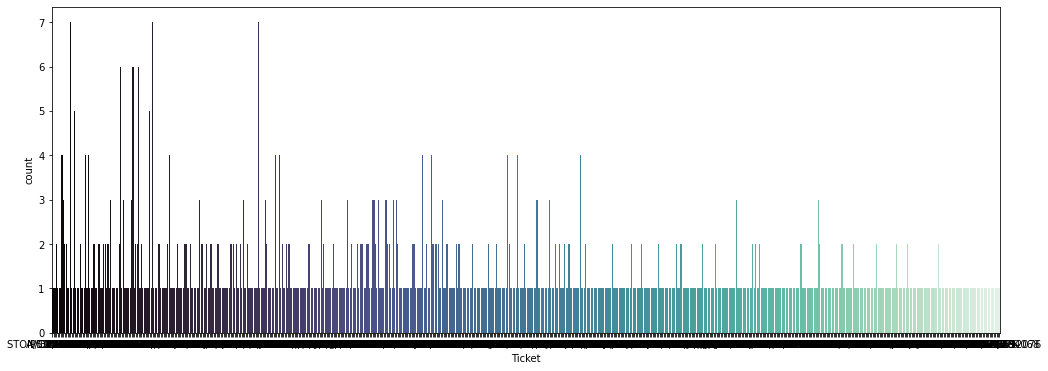

In [63]:
fig, ax = plt.subplots(figsize=(17,6))

sns.countplot(data=df_train, x='Ticket', palette='mako', ax=ax)

Alguns valores desta coluna:

In [64]:
df_train['Ticket'].sample(n = 30)

9         237736
124        35281
384       349227
546         2908
409         4133
149       244310
485         4133
0      A/5 21171
872          695
456        13509
702         2691
646       349231
522         2624
525       367232
126       370372
61        113572
782       113501
600       243847
260       384461
367         2626
404       315096
614       364512
700     PC 17757
225      PP 4348
434        13507
48          2662
406       347064
266      3101295
310        11767
690        17474
Name: Ticket, dtype: object

<font color='darkblue'>Observamos que existem alguns passageiros com Tickets repetidos, talvez por serem da mesma família, e que os tickets variam bem em seu formato, desde quantidade de números e alguns até com siglas antes dos números, não sabemos ainda o quão interessante é tratar essa variável para ser utilizada no modelo.</font>

##Fare

Tarifa de passageiro.

Tipo:

In [65]:
df_train['Fare'].dtypes

dtype('float64')

Distribuição:

Text(0.5, 1.0, 'Quantidade de passageiros por preço de ticket')

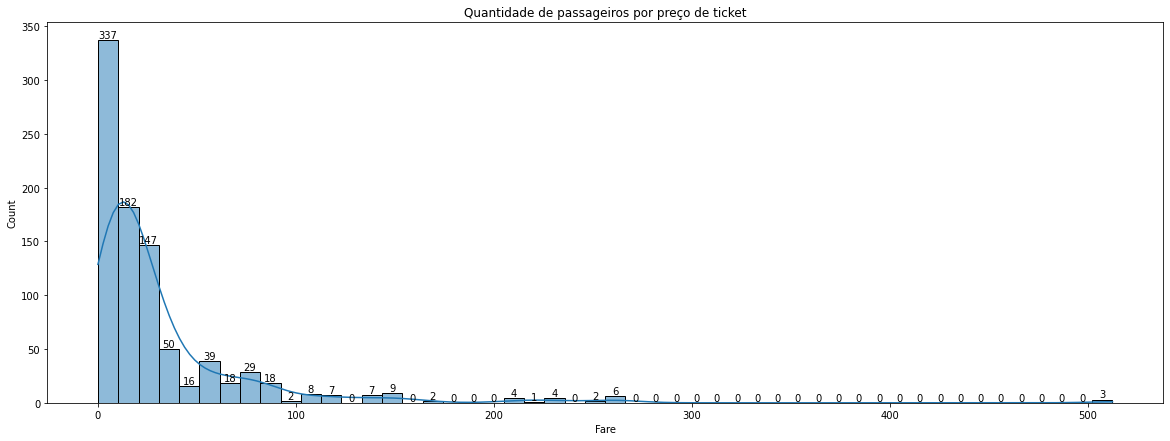

In [66]:
fig, ax = plt.subplots(figsize=(20,7))

sns.histplot(data=df_train, x='Fare' ,bins=50 ,kde=True, palette='mako', ax=ax)
ax.bar_label(ax.containers[0])
ax.set_title('Quantidade de passageiros por preço de ticket')

Text(0.5, 1.0, 'Quantidade de passageiros por preço de ticket')

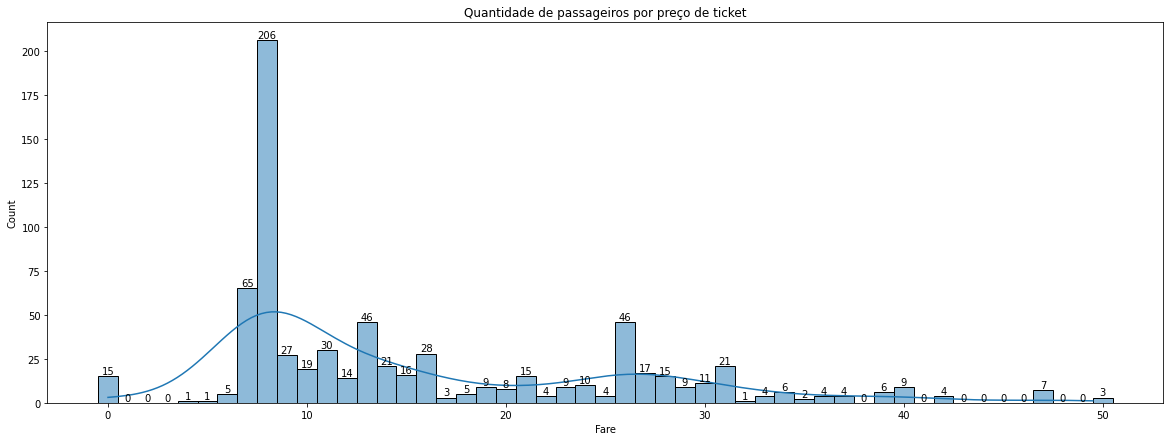

In [67]:
fig, ax = plt.subplots(figsize=(20,7))

sns.histplot(data=df_train[df_train['Fare']<50], x='Fare' ,discrete=True ,binrange=(0,50) ,kde=True, palette='mako', ax=ax)
ax.bar_label(ax.containers[0])
ax.set_title('Quantidade de passageiros por preço de ticket')

<AxesSubplot: ylabel='Fare'>

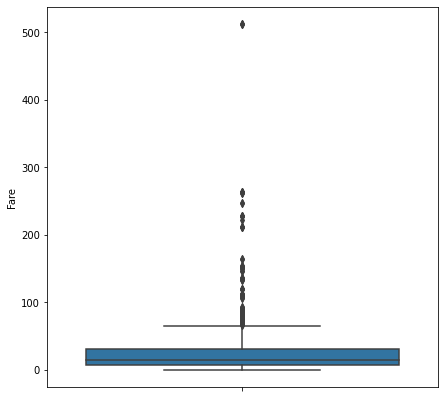

In [68]:
fig, ax = plt.subplots(figsize=(7,7))

sns.boxplot(y='Fare', data=df_train, ax=ax)

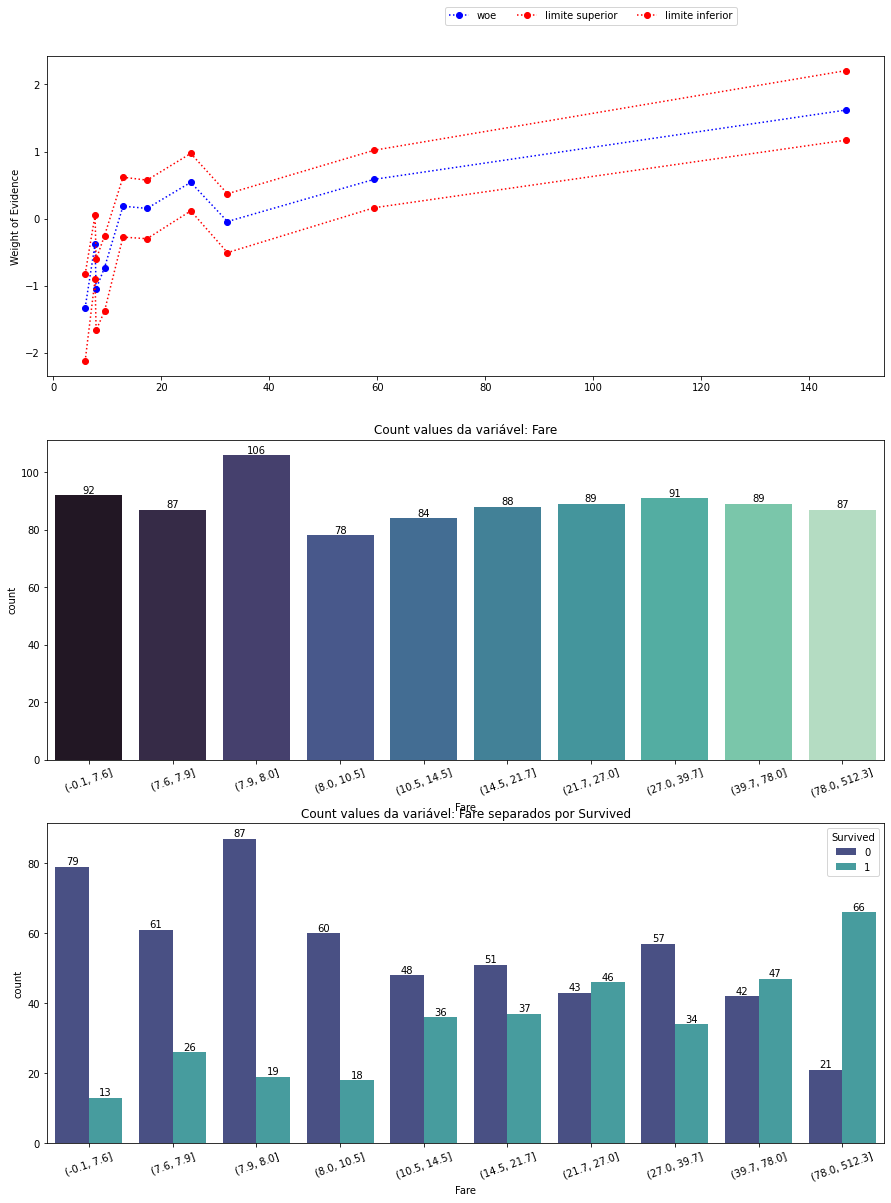

In [69]:
biv_continua(var = 'Fare',ncat = 10, df = df_train)

Identificando máximos e mínimos:

In [70]:
df_train['Fare'].nlargest(n=10)

258    512.3292
679    512.3292
737    512.3292
27     263.0000
88     263.0000
341    263.0000
438    263.0000
311    262.3750
742    262.3750
118    247.5208
Name: Fare, dtype: float64

In [71]:
df_train['Fare'].nsmallest(n=10)

179    0.0
263    0.0
271    0.0
277    0.0
302    0.0
413    0.0
466    0.0
481    0.0
597    0.0
633    0.0
Name: Fare, dtype: float64

Quantos zeros temos nessa coluna?

In [72]:
(df_train['Fare']==0).value_counts()

False    876
True      15
Name: Fare, dtype: int64

Quais os valores mais se repetem?

In [73]:
df_train['Fare'].value_counts().head(10)

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
10.5000    24
7.9250     18
7.7750     16
7.2292     15
0.0000     15
Name: Fare, dtype: int64

<font color='darkblue'>Algumas observações importantes sobre essa coluna: WOE varia bem entre os valores, mas acredito que um agrupamento desta variável seja favorável para o modelo, apesar de termos alguns valores altos o agrupamento dissolve essa diferença permitindo a não remoção destes valores como Outliers. Temos uma grande densidade de valores entre 6 e 17.</font>

##Cabin

Número da cabine.

Tipo:

In [74]:
df_train['Cabin'].dtypes

dtype('O')

Distribuição:

<AxesSubplot: xlabel='Cabin', ylabel='count'>

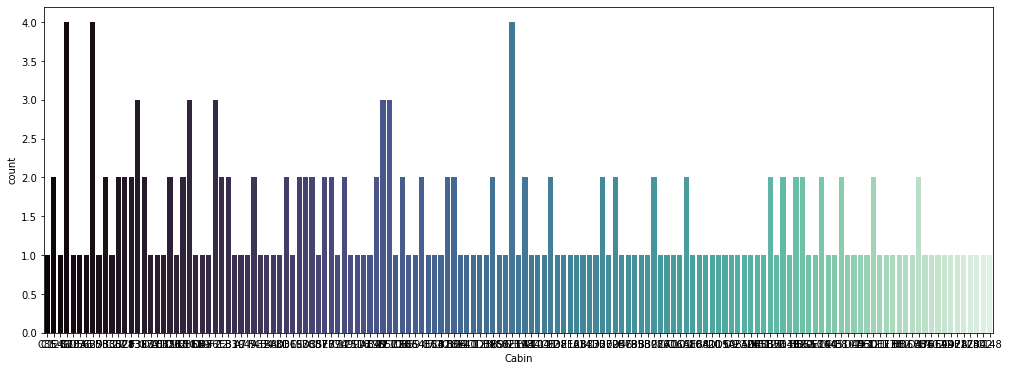

In [75]:
fig, ax = plt.subplots(figsize=(17,6))

sns.countplot(data=df_train, x='Cabin', palette='mako', ax=ax)

Acredito que o maior problema desta variável seja a quantidade de dados missing:

In [76]:
df_train['Cabin'].isnull().value_counts()

True     687
False    204
Name: Cabin, dtype: int64

Alguns valores desta coluna:

In [77]:
df_train['Cabin'][df_train['Cabin'].isnull()==False].sample(n = 30)

867        A24
139        B86
377        C82
751       E121
730         B5
715      F G73
331       C124
224        C93
136        D47
92         E31
356        E33
599        A20
609       C125
394         G6
310        C54
137       C123
453        C92
54         B30
789    B82 B84
412        C78
504        B79
11        C103
318         C7
745        B22
174         A7
102        D26
484        B49
291        B49
889       C148
550        C70
Name: Cabin, dtype: object

<font color='darkblue'>Acho válido agruparmos passageiros com cabine e sem cabine para uma análise mais aprofundada desta variável.</font>

##Embarked

Porto de embarcação.

Tipo:

In [78]:
df_train['Embarked'].dtypes

dtype('O')

Distribuição:

,qt_Died,qt_Survived,Survived,Embarked,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
Embarked,,,,,,,,,,,,,,
C,75,93,0.553571,C,168,0.038354,0.629292,0.477851,0.215111,0.529181,-0.088655,0.688399,1.002469,0.384632
Q,47,30,0.389610,Q,77,0.055574,0.500296,0.278925,-0.448950,0.001184,-0.949802,0.024337,0.474472,-0.476514
S,427,217,0.336957,S,644,0.018626,0.373531,0.300382,-0.676887,-0.517097,-0.845481,-0.203599,-0.043809,-0.372193
nan,0,2,1.000000,nan,2,0.000000,1.000000,1.000000,inf,inf,inf,inf,inf,inf


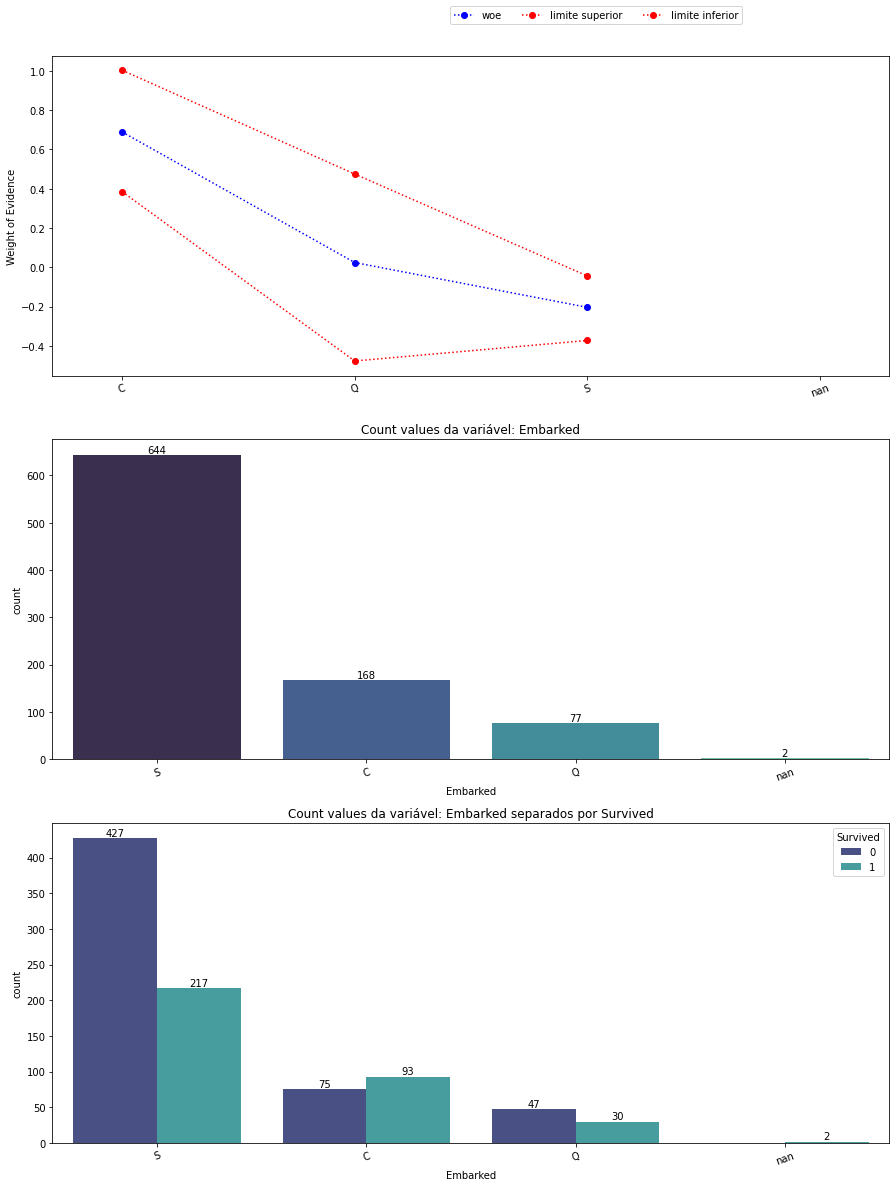

In [79]:
biv_discreta(var = 'Embarked', df = df_train)

<font color='darkblue'>Uma das três categorias aparenta ter um WOE razoável. E também precisamos tratar os 2 valores nulos existentes, muito provavelmente adicionarmos no valor mais comum não alterará muito o modelo final.</font>

# Alteração de variáveis, tratamento de dados missing e adição de novas colunas:

##Survived

Irei alterar o tipo dessa variável para booleano:

In [80]:
df_train['Survived'] = df_train['Survived'].astype('bool')
data_unseen['Survived'] = data_unseen['Survived'].astype('bool')
df_train['Survived'].dtypes

dtype('bool')

Remover do nosso DataFrame df, não utilizaremos:

In [81]:
df.drop(columns='Survived', inplace=True)

##Pclass

Irei alterar o tipo dessa variável para object:

In [82]:
df_train['Pclass'] = df_train['Pclass'].astype('O')
data_unseen['Pclass'] = data_unseen['Pclass'].astype('O')
df['Pclass'] = df['Pclass'].astype('O')
df_train['Pclass'].dtypes

dtype('O')

##Name

Criarei uma coluna categórica baseada nos pronomes de tratamento dos passageiros:

###df_train

In [83]:
df_train['Name_cat'] = 0

officer = ['Capt','Col. ','Major','Dr. ','Rev'] 
for i in officer: 
    t1 = df_train['Name'].str.contains(i)
    t2 = df_train.loc[t1]
    t3 = t2.index
    df_train['Name_cat'][t3] = 'Officer'

royal = ['Jonkheer','Don. ','Sir. ','the Countess','Lady']
for i in royal:
    t1 = df_train['Name'].str.contains(i)
    t2 = df_train.loc[t1]
    t3 = t2.index
    df_train['Name_cat'][t3] = 'Royal'

mrs = ['Mme','Ms','Mrs. ', 'Dona. ']
for i in mrs:
    t1 = df_train['Name'].str.contains(i)
    t2 = df_train.loc[t1]
    t3 = t2.index
    df_train['Name_cat'][t3] = 'Mrs'

miss = ['Mlle','Miss. ']
for i in miss:
    t1 = df_train['Name'].str.contains(i)
    t2 = df_train.loc[t1]
    t3 = t2.index
    df_train['Name_cat'][t3] = 'Miss'

master = ['Master']
for i in master:
    t1 = df_train['Name'].str.contains(i)
    t2 = df_train.loc[t1]
    t3 = t2.index
    df_train['Name_cat'][t3] = 'Master'
    
mr = ['Mr. ']
for i in mr:
    t1 = df_train['Name'].str.contains(i)
    t2 = df_train.loc[t1]
    t3 = t2.index
    df_train['Name_cat'][t3] = 'Mr'

In [84]:
df_train['Name_cat'].value_counts()

Mr         521
Miss       181
Mrs        127
Master      40
Officer     18
Royal        4
Name: Name_cat, dtype: int64

###Descritiva *Name_cat*

Tipo:

In [85]:
df_train['Name_cat'].dtypes

dtype('O')

Distribuição:

,qt_Died,qt_Survived,Survived,Name_cat,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
Name_cat,,,,,,,,,,,,,,
Master,17,23,0.575000,Master,40,0.078162,0.733099,0.416901,0.302281,1.010401,-0.335506,0.775569,1.483688,0.137781
Miss,54,127,0.701657,Miss,181,0.034008,0.768763,0.634552,0.855203,1.201340,0.551795,1.328491,1.674628,1.025082
Mr,437,84,0.161228,Mr,521,0.016111,0.192879,0.129578,-1.649116,-1.431410,-1.904698,-1.175829,-0.958122,-1.431410
Mrs,26,101,0.795276,Mrs,127,0.035805,0.866132,0.724419,1.357024,1.867186,0.966488,1.830312,2.340474,1.439775
Officer,13,5,0.277778,Officer,18,0.105572,0.500515,0.055041,-0.955511,0.002059,-2.843068,-0.482224,0.475347,-2.369780
Royal,2,2,0.500000,Royal,4,0.250000,1.295612,-0.295612,0.000000,NaN,NaN,0.473288,NaN,NaN


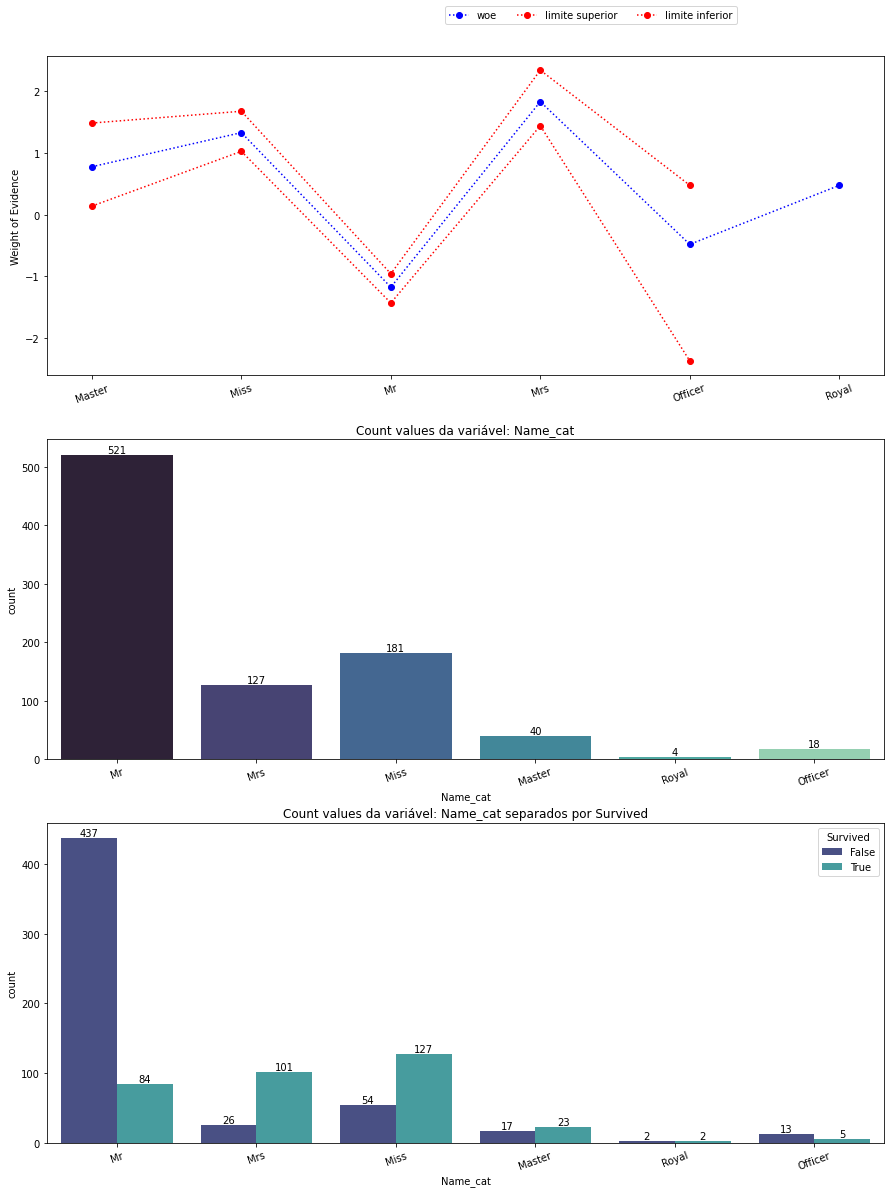

In [86]:
biv_discreta(var = 'Name_cat', df = df_train)

<font color='darkblue'>Encontramos bons valores de WOE para a maioria das categorias, talvez seja uma boa variável para o modelo.</font>

###data_unseen

In [87]:
data_unseen['Name_cat'] = 0

officer = ['Capt','Col. ','Major','Dr. ','Rev'] 
for i in officer: 
    t1 = data_unseen['Name'].str.contains(i)
    t2 = data_unseen.loc[t1]
    t3 = t2.index
    data_unseen['Name_cat'][t3] = 'Officer'

royal = ['Jonkheer','Don. ','Sir. ','the Countess','Lady']
for i in royal:
    t1 = data_unseen['Name'].str.contains(i)
    t2 = data_unseen.loc[t1]
    t3 = t2.index
    data_unseen['Name_cat'][t3] = 'Royal'

mrs = ['Mme','Ms','Mrs. ', 'Dona. ']
for i in mrs:
    t1 = data_unseen['Name'].str.contains(i)
    t2 = data_unseen.loc[t1]
    t3 = t2.index
    data_unseen['Name_cat'][t3] = 'Mrs'

miss = ['Mlle','Miss. ']
for i in miss:
    t1 = data_unseen['Name'].str.contains(i)
    t2 = data_unseen.loc[t1]
    t3 = t2.index
    data_unseen['Name_cat'][t3] = 'Miss'

master = ['Master']
for i in master:
    t1 = data_unseen['Name'].str.contains(i)
    t2 = data_unseen.loc[t1]
    t3 = t2.index
    data_unseen['Name_cat'][t3] = 'Master'
    
mr = ['Mr. ']
for i in mr:
    t1 = data_unseen['Name'].str.contains(i)
    t2 = data_unseen.loc[t1]
    t3 = t2.index
    data_unseen['Name_cat'][t3] = 'Mr'

In [88]:
data_unseen['Name_cat'].value_counts()

Mr         240
Miss        78
Mrs         74
Master      21
Officer      5
Name: Name_cat, dtype: int64

###df

In [89]:
df['Name'].isnull().value_counts()

False    1309
Name: Name, dtype: int64

In [90]:
df['Name_cat'] = 0

officer = ['Capt','Col. ','Major','Dr. ','Rev'] 
for i in officer: 
    t1 = df['Name'].str.contains(i)
    t2 = df.loc[t1]
    t3 = t2.index
    df['Name_cat'][t3] = 'Officer'

royal = ['Jonkheer','Don. ','Sir. ','the Countess','Lady']
for i in royal:
    t1 = df['Name'].str.contains(i)
    t2 = df.loc[t1]
    t3 = t2.index
    df['Name_cat'][t3] = 'Royal'

mrs = ['Mme','Ms','Mrs. ', 'Dona. ']
for i in mrs:
    t1 = df['Name'].str.contains(i)
    t2 = df.loc[t1]
    t3 = t2.index
    df['Name_cat'][t3] = 'Mrs'

miss = ['Mlle','Miss. ']
for i in miss:
    t1 = df['Name'].str.contains(i)
    t2 = df.loc[t1]
    t3 = t2.index
    df['Name_cat'][t3] = 'Miss'

master = ['Master']
for i in master:
    t1 = df['Name'].str.contains(i)
    t2 = df.loc[t1]
    t3 = t2.index
    df['Name_cat'][t3] = 'Master'
    
mr = ['Mr. ']
for i in mr:
    t1 = df['Name'].str.contains(i)
    t2 = df.loc[t1]
    t3 = t2.index
    df['Name_cat'][t3] = 'Mr'

##Age

###Tratamento dos dados Missing:

Apenas para armazenar o valor anterior de *Age*:

In [91]:
df_2 = df_train[['Survived', 'Age']]
df_3 = df_train[['Survived', 'Age']]
df_4 = df_train[['Survived', 'Age']]
df_5 = data_unseen[['Survived', 'Age']]

Irei substituir os valores missing pelas médias das idades de cada categoria criada pela variável Age para dissolver um pouco os novos dados ao longo da nossa distribuição de valores de idade.

In [92]:
AgeMean_train = df_train.groupby(['Name_cat'])['Age'].mean().round(2).to_dict()
AgeMean_test = data_unseen.groupby(['Name_cat'])['Age'].mean().round(2).to_dict()
AgeMean_train

{'Master': 4.57,
 'Miss': 21.79,
 'Mr': 32.33,
 'Mrs': 35.72,
 'Officer': 46.71,
 'Royal': 40.0}

In [93]:
df_train.loc[np.isnan(df_train["Age"]), 'Age'] = df_train['Name_cat'].map(AgeMean_train)
data_unseen.loc[np.isnan(data_unseen["Age"]), 'Age'] = data_unseen['Name_cat'].map(AgeMean_test)

Verificando nova distribuição de dados da variável *Age*:

Text(0.5, 1.0, 'Quantidade de passageiros por idade')

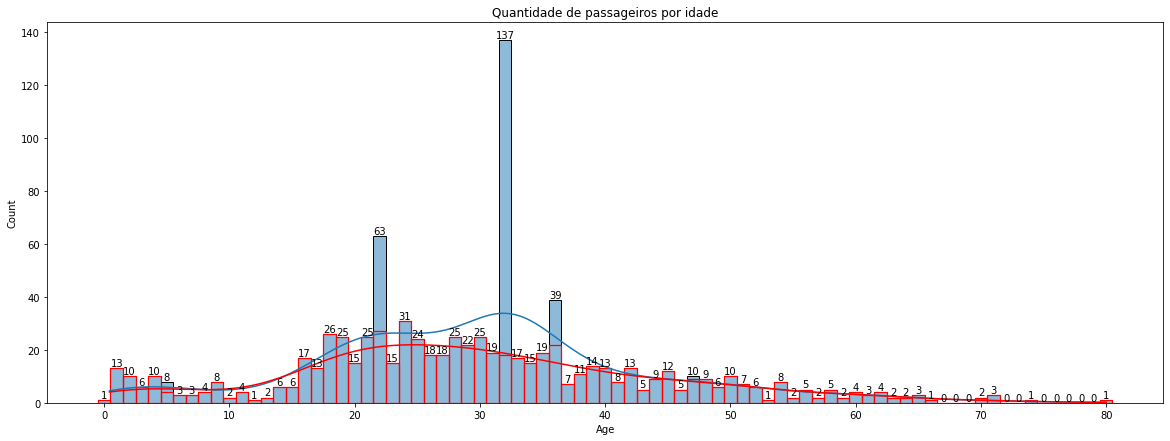

In [94]:
fig, ax = plt.subplots(figsize=(20,7))

sns.histplot(data=df_train, x='Age',discrete=True ,binrange=(0,80) ,kde=True, palette='mako', ax=ax)
sns.histplot(data=df_2, x='Age',discrete=True ,binrange=(0,80) ,kde=True, palette='mako', color='red', ax=ax, fill=False)
ax.bar_label(ax.containers[0])
ax.set_title('Quantidade de passageiros por idade')

Caso utilizassemos apenas a média geral para preenchimento dos nulos:

In [95]:
df_3['Age'].fillna(df_3['Age'].mean(), inplace=True)

Text(0.5, 1.0, 'Quantidade de passageiros por idade')

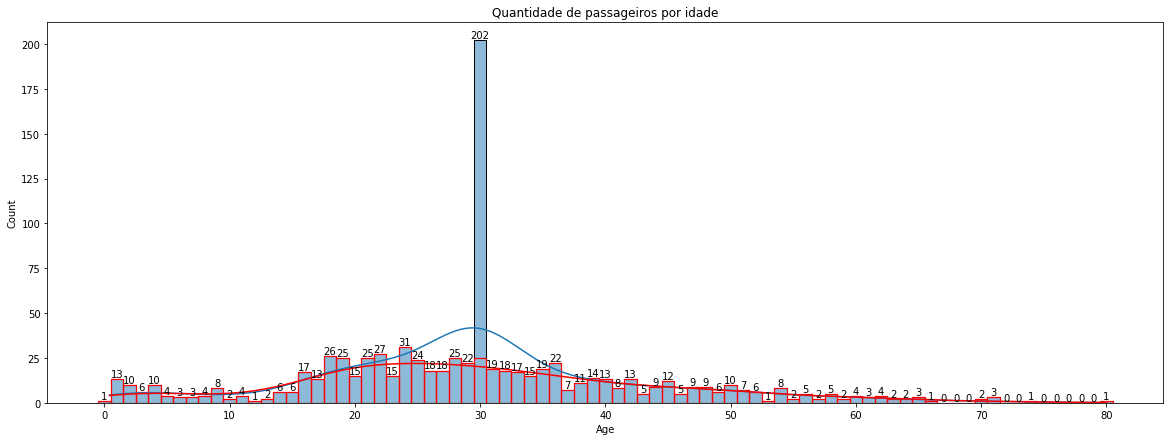

In [96]:
fig, ax = plt.subplots(figsize=(20,7))

sns.histplot(data=df_3, x='Age',discrete=True ,binrange=(0,80) ,kde=True, palette='mako', ax=ax)
sns.histplot(data=df_2, x='Age',discrete=True ,binrange=(0,80) ,kde=True, palette='mako', color='red', ax=ax, fill=False)
ax.bar_label(ax.containers[0])
ax.set_title('Quantidade de passageiros por idade')

<font color='darkblue'>Realmente substituir apenas pela média geral causa um aumento muito grande no volume de dados em um ponto só, inserir médias por categoria influenciou menos bruscamente na distribuição dos dados.</font>

###Criação da variável categórica para idade:

Irei categorizar esta variável em uma nova coluna:

In [97]:
df_train['Age_Cat'], bins_Age = pd.qcut(df_train['Age'], 20, duplicates='drop', retbins=True)
df_train['Age_Cat']

0      (21.79, 22.0]
1      (35.72, 38.0]
2       (24.0, 26.0]
3      (34.0, 35.72]
4      (34.0, 35.72]
           ...      
886     (26.0, 28.0]
887     (18.0, 20.0]
888    (20.0, 21.79]
889     (24.0, 26.0]
890    (30.0, 32.33]
Name: Age_Cat, Length: 891, dtype: category
Categories (18, interval[float64, right]): [(0.419, 5.0] < (5.0, 16.0] < (16.0, 18.0] <
                                            (18.0, 20.0] ... (38.0, 42.0] < (42.0, 47.0] <
                                            (47.0, 54.0] < (54.0, 80.0]]

In [98]:
data_unseen['Age'][data_unseen['Age']<0.5] = 0.5
data_unseen['Age'][data_unseen['Age']>79] = 79

In [99]:
data_unseen['Age_Cat'] = pd.cut(data_unseen['Age'], bins=bins_Age)

###Descritiva

,qt_Died,qt_Survived,Survived,Age_Cat,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
Age_Cat,,,,,,,,,,,,,,
"(0.419, 5.0]",15,33,0.687500,"(0.419, 5.0]",48,0.066902,0.822090,0.552910,0.788457,1.530572,0.212435,1.261745,2.003860,0.685723
"(16.0, 18.0]",24,15,0.384615,"(16.0, 18.0]",39,0.077903,0.542322,0.226909,-0.470004,0.169693,-1.225848,0.003284,0.642981,-0.752560
"(18.0, 20.0]",28,12,0.300000,"(18.0, 20.0]",40,0.072457,0.446558,0.153442,-0.847298,-0.214588,-1.707855,-0.374010,0.258700,-1.234567
"(20.0, 21.79]",34,27,0.442623,"(20.0, 21.79]",61,0.063596,0.569833,0.315413,-0.230524,0.281170,-0.774933,0.242764,0.754457,-0.301645
"(21.79, 22.0]",16,11,0.407407,"(21.79, 22.0]",27,0.094561,0.601780,0.213035,-0.374693,0.412886,-1.306727,0.098594,0.886174,-0.833439
"(22.0, 24.0]",26,20,0.434783,"(22.0, 24.0]",46,0.073091,0.581996,0.287569,-0.262364,0.330972,-0.907218,0.210923,0.804259,-0.433930
"(24.0, 26.0]",30,12,0.285714,"(24.0, 26.0]",42,0.069707,0.426491,0.144938,-0.916291,-0.296183,-1.774869,-0.443003,0.177104,-1.301581
"(26.0, 28.0]",25,18,0.418605,"(26.0, 28.0]",43,0.075232,0.570429,0.266780,-0.328504,0.283603,-1.011021,0.144784,0.756891,-0.537734
"(28.0, 30.0]",29,18,0.382979,"(28.0, 30.0]",47,0.070907,0.525707,0.240251,-0.476924,0.102918,-1.151306,-0.003636,0.576206,-0.678019


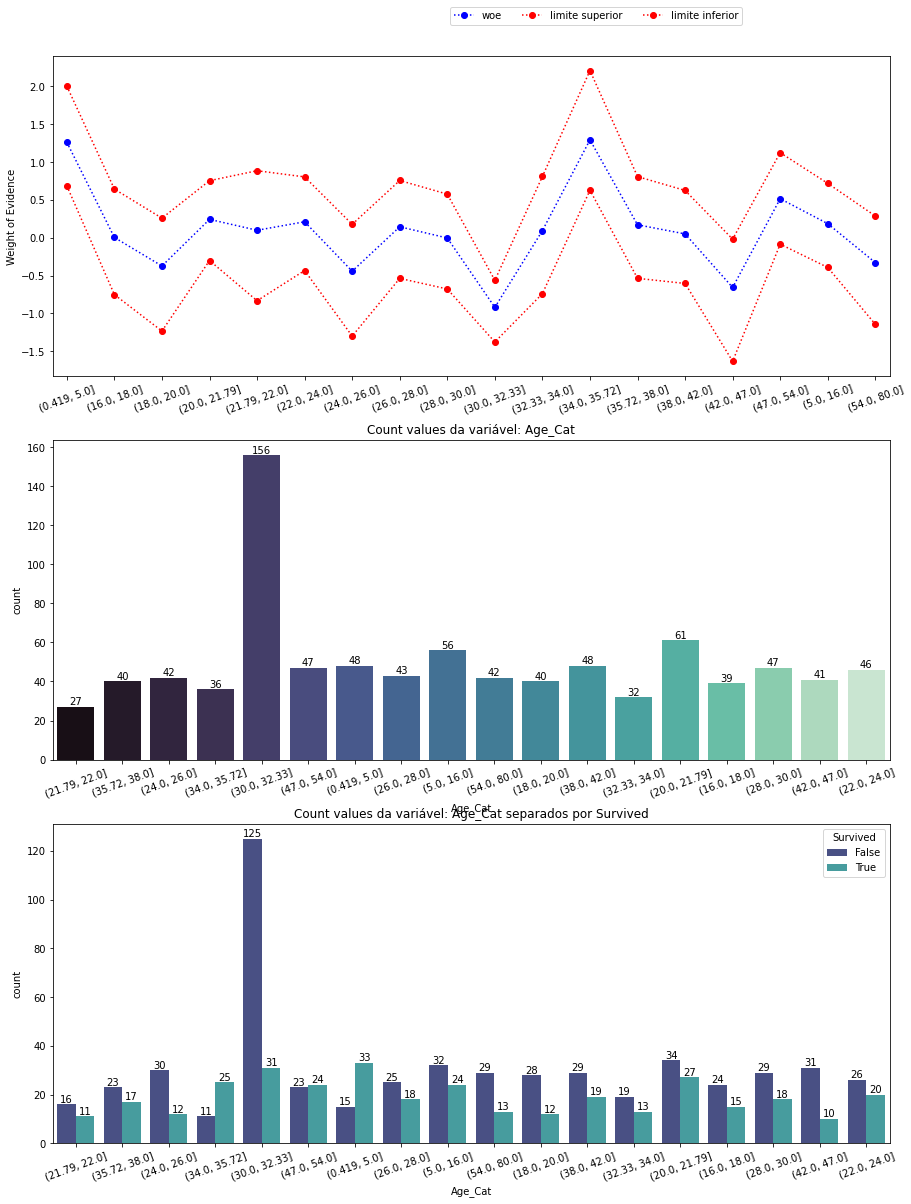

In [100]:
biv_discreta(var='Age_Cat', df=df_train)

<font color='darkblue'>Apesar de alguns grupos possuirem um WOE aceitável a maioria dos grupos apresenta um WOE beirando o zero, talvez não seja uma variável explicativa muito eficiente para nosso modelo.</font>

##SibSp

Aqui irei fazer duas coisas, primeiro criar uma variável com o tamanho da familia e depois categorizar a variável SibSp.

###Fsize

In [101]:
df_train['Fsize'] = df_train['SibSp'].astype(int) + df_train['Parch'].astype(int) + 1
data_unseen['Fsize'] = data_unseen['SibSp'].astype(int) + data_unseen['Parch'].astype(int) + 1
df['Fsize'] = df['SibSp'].astype(int) + df['Parch'].astype(int) + 1

Distribuição:

,qt_Died,qt_Survived,Survived,Fsize,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
Fsize,,,,,,,,,,,,,,
1,374,163,0.303538,1,537,0.019841,0.342514,0.264562,-0.830506,-0.652110,-1.022390,-0.357218,-0.178822,-0.549102
11,7,0,0.000000,11,7,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
2,72,89,0.552795,2,161,0.039185,0.630182,0.475408,0.211970,0.532998,-0.098447,0.685258,1.006285,0.374840
3,43,59,0.578431,3,102,0.048894,0.675425,0.481438,0.316337,0.732825,-0.074283,0.789625,1.206113,0.399005
4,8,21,0.724138,4,29,0.082996,0.894148,0.554128,0.965081,2.133826,0.217364,1.438369,2.607114,0.690652
5,12,3,0.200000,5,15,0.103280,0.421513,-0.021513,-1.386294,-0.316567,NaN,-0.913007,0.156721,NaN
6,19,3,0.136364,6,22,0.073165,0.288519,-0.015791,-1.845827,-0.902590,NaN,-1.372539,-0.429302,NaN
7,8,4,0.333333,7,12,0.136083,0.632849,0.033817,-0.693147,0.544461,-3.352384,-0.219859,1.017748,-2.879096
8,6,0,0.000000,8,6,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf


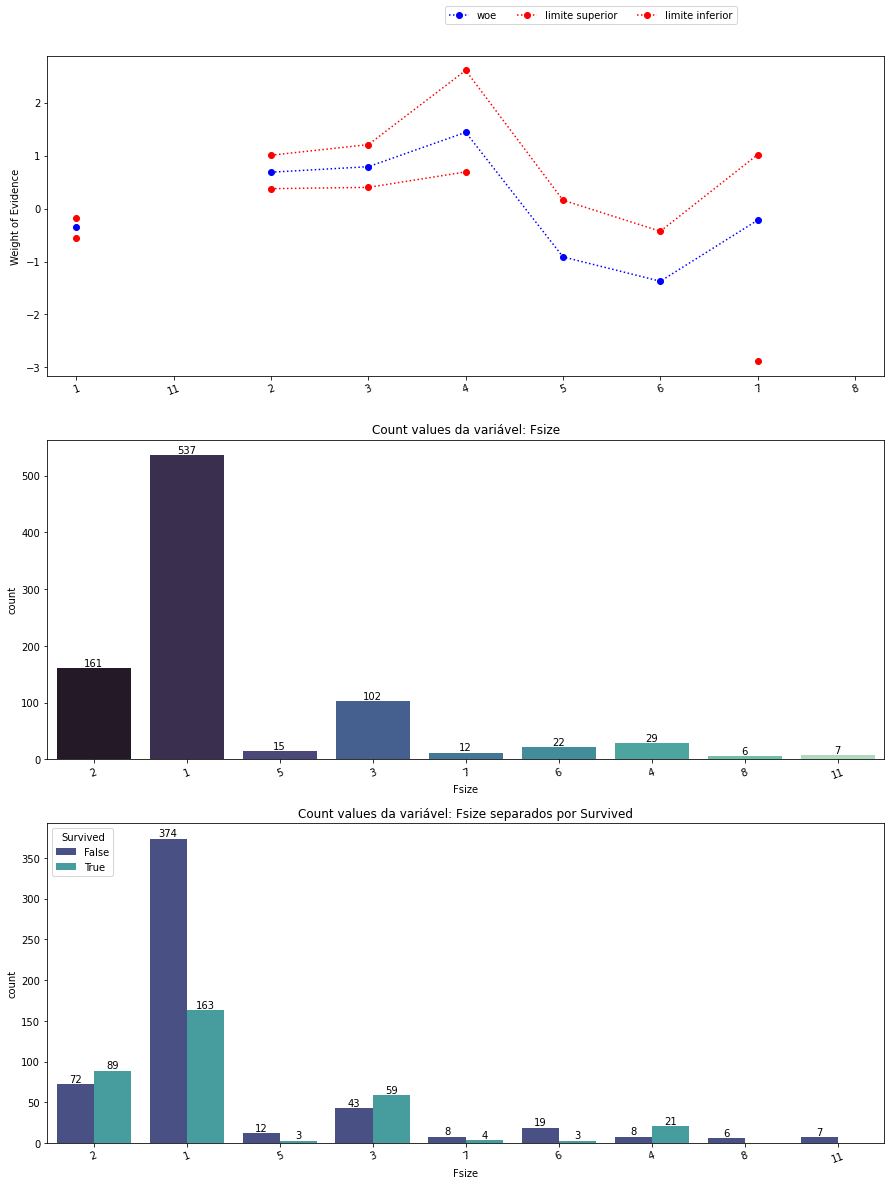

In [102]:
biv_discreta(var = 'Fsize', df = df_train)

Como a partir de 5 já não temos muita precisão de análise irei categorizar esta variável em 5 grupo

In [103]:
df_train['Fsize'] = df_train['Fsize'].astype(int)
data_unseen['Fsize'] = data_unseen['Fsize'].astype(int)
df['Fsize'] = df['Fsize'].astype(int)

df_train['Fsize'][df_train['Fsize']>4]=5
data_unseen['Fsize'][data_unseen['Fsize']>4]=5
df['Fsize'][df['Fsize']>4]=5

df_train['Fsize'] = df_train['Fsize'].astype('O')
data_unseen['Fsize'] = data_unseen['Fsize'].astype('O')
df['Fsize'] = df['Fsize'].astype('O')

dict_Fsize = {1:'One', 2:'Two', 3:'Three', 4:'Four', 5:'Five or more'}

df_train.replace({'Fsize': dict_Fsize},inplace=True)
data_unseen.replace({'Fsize': dict_Fsize},inplace=True)
df.replace({'Fsize': dict_Fsize},inplace=True)

df_train['Fsize'] = df_train['Fsize'].astype('O')
data_unseen['Fsize'] = data_unseen['Fsize'].astype('O')
df['Fsize'] = df['Fsize'].astype('O')

,qt_Died,qt_Survived,Survived,Fsize,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
Fsize,,,,,,,,,,,,,,
Five or more,52,10,0.161290,Five or more,62,0.046710,0.254694,0.067887,-1.648659,-1.073734,-2.619610,-1.175371,-0.600446,-2.146322
Four,8,21,0.724138,Four,29,0.082996,0.894148,0.554128,0.965081,2.133826,0.217364,1.438369,2.607114,0.690652
One,374,163,0.303538,One,537,0.019841,0.342514,0.264562,-0.830506,-0.652110,-1.022390,-0.357218,-0.178822,-0.549102
Three,43,59,0.578431,Three,102,0.048894,0.675425,0.481438,0.316337,0.732825,-0.074283,0.789625,1.206113,0.399005
Two,72,89,0.552795,Two,161,0.039185,0.630182,0.475408,0.211970,0.532998,-0.098447,0.685258,1.006285,0.374840


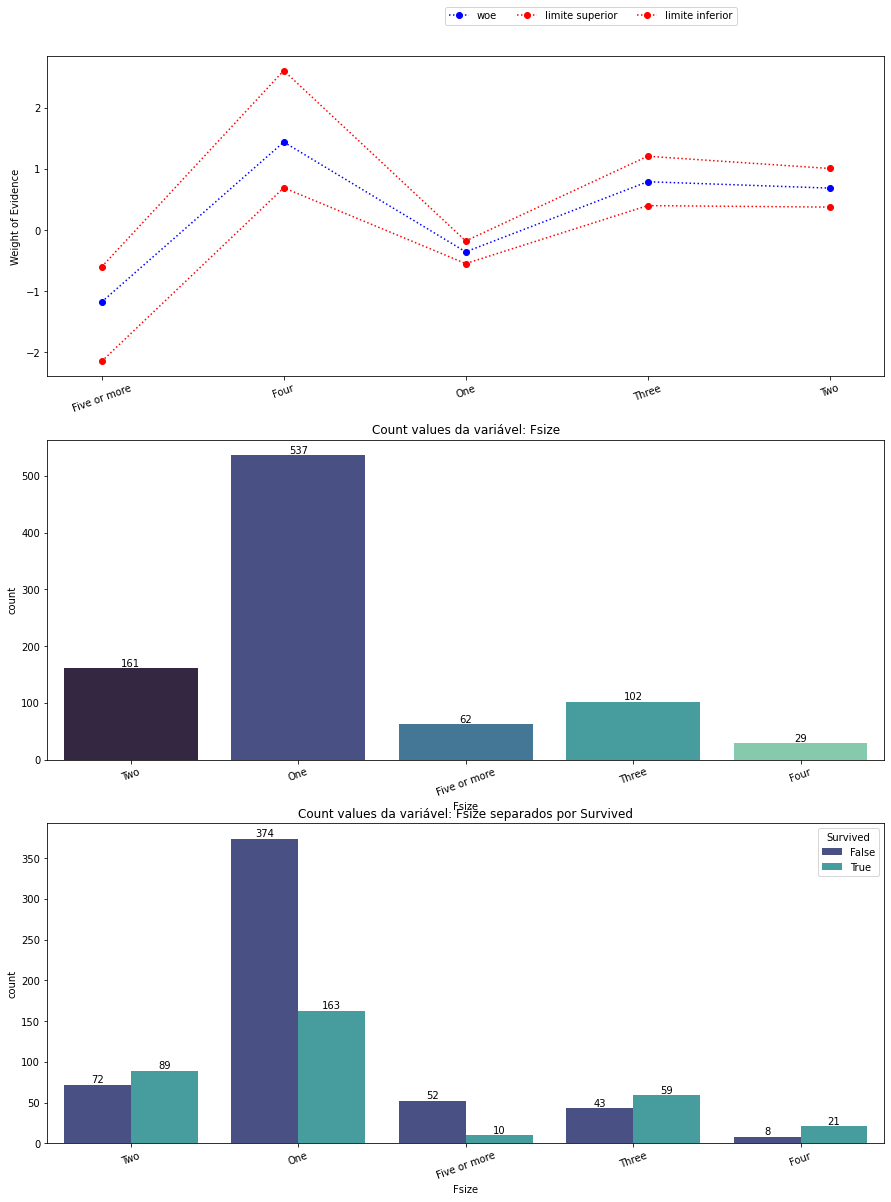

In [104]:
biv_discreta(var = 'Fsize', df = df_train)

###Agrupamento

In [105]:
df_train['SibSp'] = df_train['SibSp'].astype(int)
data_unseen['SibSp'] = data_unseen['SibSp'].astype(int)
df['SibSp'] = df['SibSp'].astype(int)

df_train['SibSp'][df_train['SibSp']>1]=2
data_unseen['SibSp'][data_unseen['SibSp']>1]=2
df['SibSp'][df['SibSp']>1]=2

df_train['SibSp'] = df_train['SibSp'].astype('O')
data_unseen['SibSp'] = data_unseen['SibSp'].astype('O')
df['SibSp'] = df['SibSp'].astype('O')

dict_SibSp = {0:'Zero', 1:'One', 2:'Two or more'}

df_train.replace({'SibSp': dict_SibSp},inplace=True)
data_unseen.replace({'SibSp': dict_SibSp},inplace=True)
df.replace({'SibSp': dict_SibSp},inplace=True)

df_train['SibSp'] = df_train['SibSp'].astype('O')
data_unseen['SibSp'] = data_unseen['SibSp'].astype('O')
df['SibSp'] = df['SibSp'].astype('O')

Distribuição:

,qt_Died,qt_Survived,Survived,SibSp,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
SibSp,,,,,,,,,,,,,,
One,97,112,0.535885,One,209,0.034497,0.603893,0.467878,0.143788,0.421712,-0.128667,0.617076,0.895000,0.344621
Two or more,54,20,0.270270,Two or more,74,0.051626,0.373160,0.167381,-0.993252,-0.518685,-1.604305,-0.519964,-0.045397,-1.131017
Zero,398,210,0.345395,Zero,608,0.019284,0.383266,0.307523,-0.639344,-0.475708,-0.811723,-0.166057,-0.002420,-0.338436


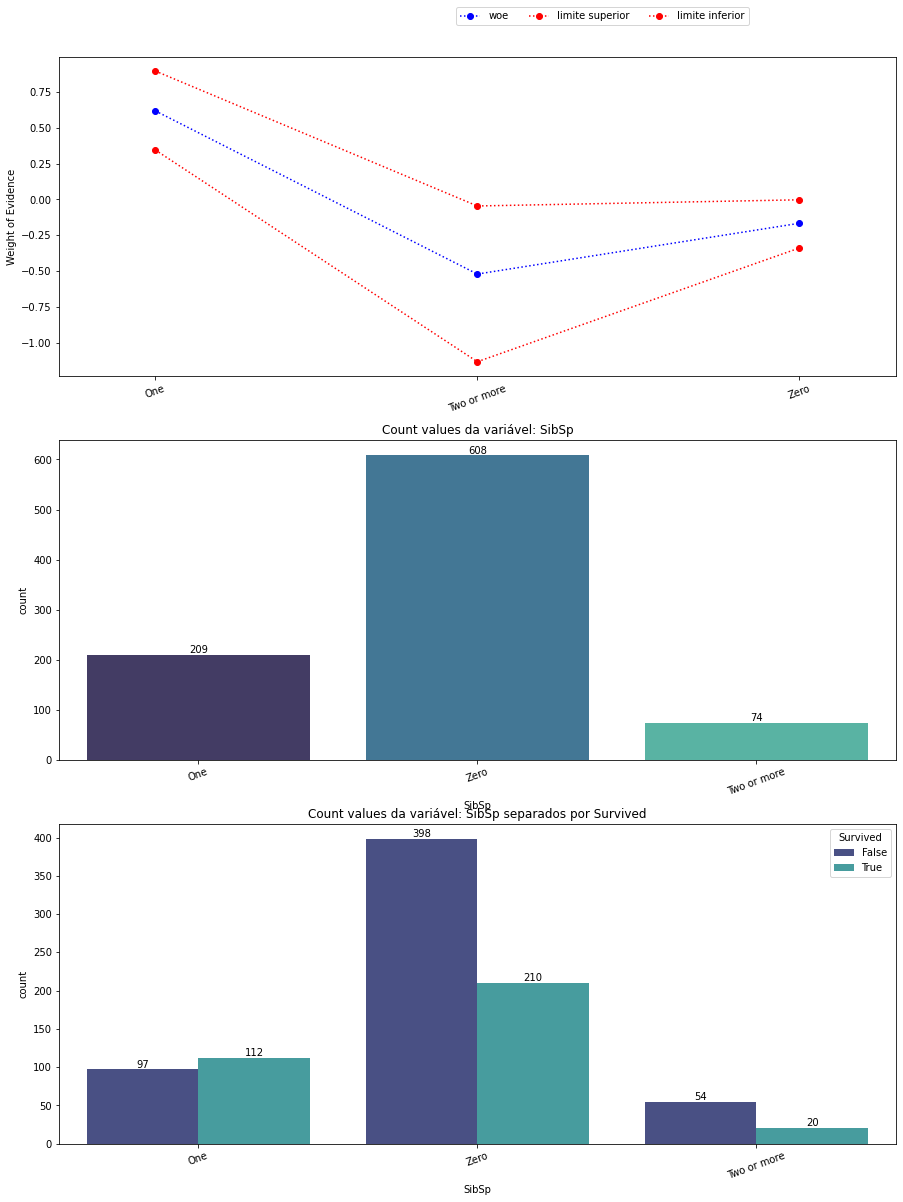

In [106]:
biv_discreta(var = 'SibSp', df = df_train)

##Parch

Categorizar a variável.

In [107]:
df_train['Parch'] = df_train['Parch'].astype(int)
data_unseen['Parch'] = data_unseen['Parch'].astype(int)
df['Parch'] = df['Parch'].astype(int)

df_train['Parch'][df_train['Parch']>2]=3
data_unseen['Parch'][data_unseen['Parch']>2]=3
df['Parch'][df['Parch']>2]=3

df_train['Parch'] = df_train['Parch'].astype('O')
data_unseen['Parch'] = data_unseen['Parch'].astype('O')
df['Parch'] = df['Parch'].astype('O')

dict_Parch = {0:'Zero', 1:'One', 2:'Two', 3:'Three or more'}

df_train.replace({'Parch': dict_Parch},inplace=True)
data_unseen.replace({'Parch': dict_Parch},inplace=True)
df.replace({'Parch': dict_Parch},inplace=True)

df_train['Parch'] = df_train['Parch'].astype('O')
data_unseen['Parch'] = data_unseen['Parch'].astype('O')
df['Parch'] = df['Parch'].astype('O')

Distribuição:

,qt_Died,qt_Survived,Survived,Parch,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
Parch,,,,,,,,,,,,,,
One,53,65,0.550847,One,118,0.045790,0.641532,0.460163,0.204095,0.582021,-0.159688,0.677383,1.055309,0.313599
Three or more,11,4,0.266667,Three or more,15,0.114180,0.511558,0.021775,-1.011601,0.046241,-3.804965,-0.538313,0.519528,-3.331678
Two,40,40,0.500000,Two,80,0.055902,0.611270,0.388730,0.000000,0.452652,-0.452652,0.473288,0.925940,0.020636
Zero,445,233,0.343658,Zero,678,0.018240,0.379471,0.307845,-0.647036,-0.491796,-0.810214,-0.173748,-0.018508,-0.336926


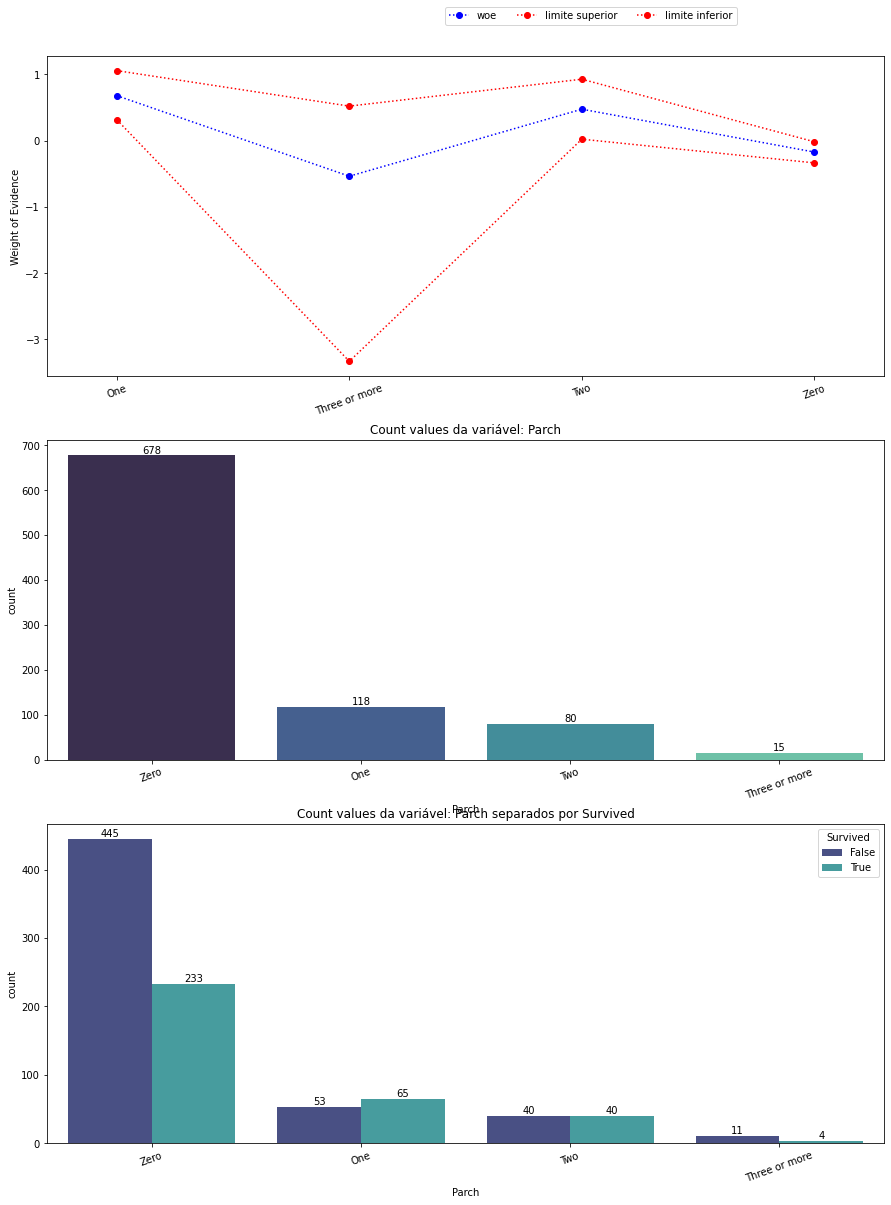

In [108]:
biv_discreta(var = 'Parch', df = df_train)

##Fare

Vamos criar uma coluna categórica para esta variável:

In [109]:
df_train['Fare_Cat'], bins_Fare = pd.qcut(df_train['Fare'], 20, duplicates='drop', retbins=True)
df_train['Fare_Cat']

0         (7.225, 7.55]
1      (56.496, 77.958]
2          (7.91, 8.05]
3      (39.688, 56.496]
4          (7.91, 8.05]
             ...       
886        (10.5, 13.0]
887        (27.0, 31.0]
888      (21.679, 26.0]
889        (27.0, 31.0]
890        (7.55, 7.75]
Name: Fare_Cat, Length: 891, dtype: category
Categories (20, interval[float64, right]): [(-0.001, 7.225] < (7.225, 7.55] < (7.55, 7.75] <
                                            (7.75, 7.854] ... (39.688, 56.496] <
                                            (56.496, 77.958] < (77.958, 112.079] <
                                            (112.079, 512.329]]

In [110]:
data_unseen['Fare'].fillna(data_unseen['Fare'].median(), inplace = True)
data_unseen['Fare'][data_unseen['Fare']<0] = 0
data_unseen['Fare'][data_unseen['Fare']>400] = 400

df['Fare'].fillna(df['Fare'].median(), inplace = True)
df['Fare'][df['Fare']<0] = 0
df['Fare'][df['Fare']>400] = 400

In [111]:
data_unseen['Fare_Cat'] = pd.cut(data_unseen['Fare'], bins=bins_Fare)

Descritiva

,qt_Died,qt_Survived,Survived,Fare_Cat,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
Fare_Cat,,,,,,,,,,,,,,
"(-0.001, 7.225]",49,6,0.109091,"(-0.001, 7.225]",55,0.042037,0.193370,0.024812,-2.100061,-1.428262,-3.671294,-1.626773,-0.954974,-3.198007
"(10.5, 13.0]",35,30,0.461538,"(10.5, 13.0]",65,0.061834,0.585065,0.338012,-0.154151,0.343602,-0.672168,0.319137,0.816890,-0.198880
"(112.079, 512.329]",11,34,0.755556,"(112.079, 512.329]",45,0.064064,0.884669,0.626442,1.128465,2.037407,0.516984,1.601753,2.510695,0.990271
"(13.0, 14.454]",13,6,0.315789,"(13.0, 14.454]",19,0.106639,0.539830,0.091749,-0.773190,0.159659,-2.292466,-0.299902,0.632947,-1.819179
"(14.454, 16.1]",29,18,0.382979,"(14.454, 16.1]",47,0.070907,0.525707,0.240251,-0.476924,0.102918,-1.151306,-0.003636,0.576206,-0.678019
"(16.1, 21.679]",22,19,0.463415,"(16.1, 21.679]",41,0.077878,0.620811,0.306018,-0.146603,0.492992,-0.818801,0.326684,0.966280,-0.345513
"(21.679, 26.0]",33,28,0.459016,"(21.679, 26.0]",61,0.063803,0.586641,0.331391,-0.164303,0.350098,-0.701899,0.308985,0.823386,-0.228611
"(26.0, 27.0]",10,18,0.642857,"(26.0, 27.0]",28,0.090552,0.828655,0.457059,0.587787,1.576125,-0.172187,1.061074,2.049413,0.301101
"(27.0, 31.0]",27,18,0.400000,"(27.0, 31.0]",45,0.073030,0.547182,0.252818,-0.405465,0.189290,-1.083637,0.067823,0.662577,-0.610349


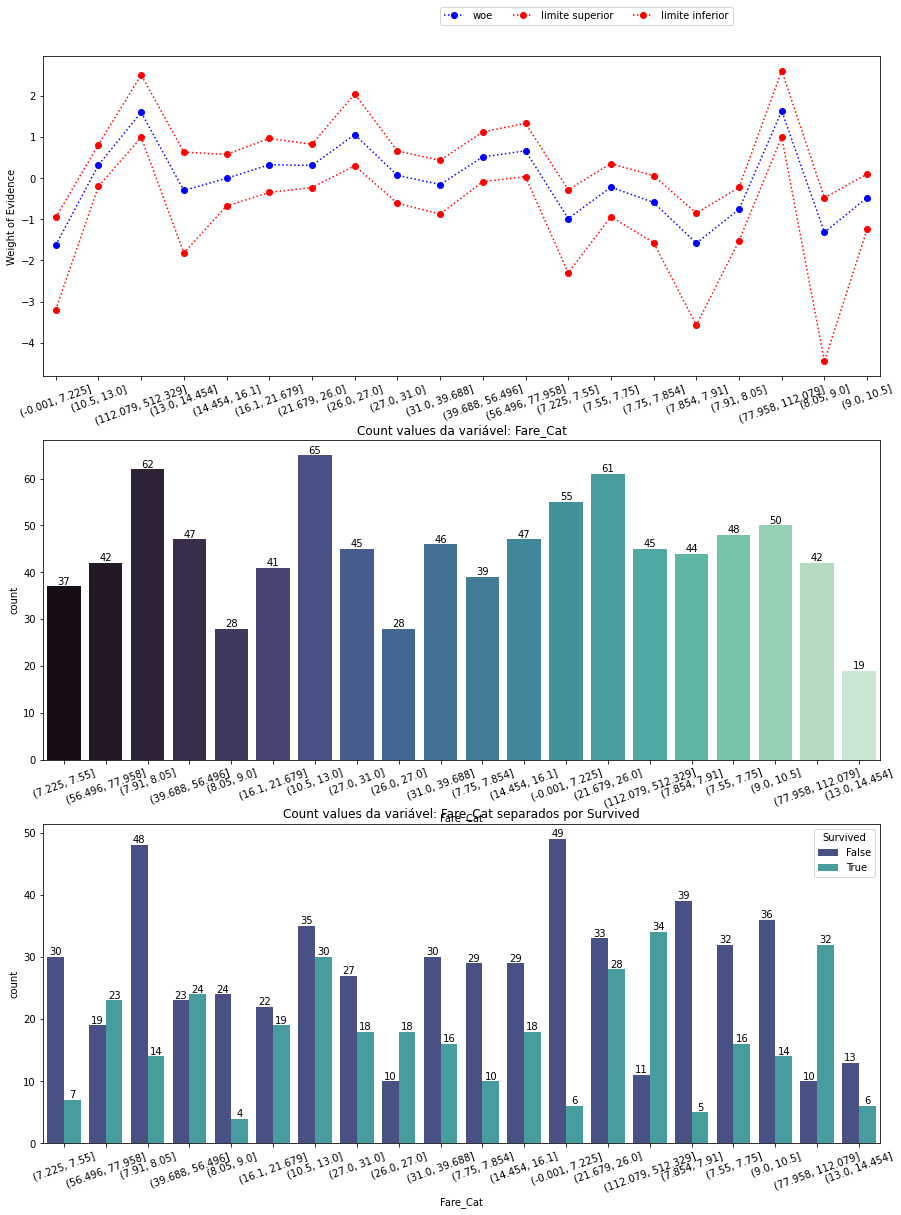

In [112]:
biv_discreta(var='Fare_Cat', df=df_train)

##Cabin

Irei criar uma coluna que indique o passageiro ter ou não uma Cabine:

In [113]:
df_train['CabinYN'] = (df_train['Cabin'].notnull())
data_unseen['CabinYN'] = (data_unseen['Cabin'].notnull()).astype('O')
df['CabinYN'] = (df['Cabin'].notnull()).astype('O')

Distribuição

,qt_Died,qt_Survived,Survived,CabinYN,cont,ep,Survived_sup,Survived_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
CabinYN,,,,,,,,,,,,,,
False,481,206,0.299854,False,687,0.017481,0.334178,0.265531,-0.847991,-0.689351,-1.017414,-0.374703,-0.216063,-0.544127
True,68,136,0.666667,True,204,0.033005,0.731743,0.601590,0.693147,1.003484,0.412096,1.166435,1.476772,0.885383


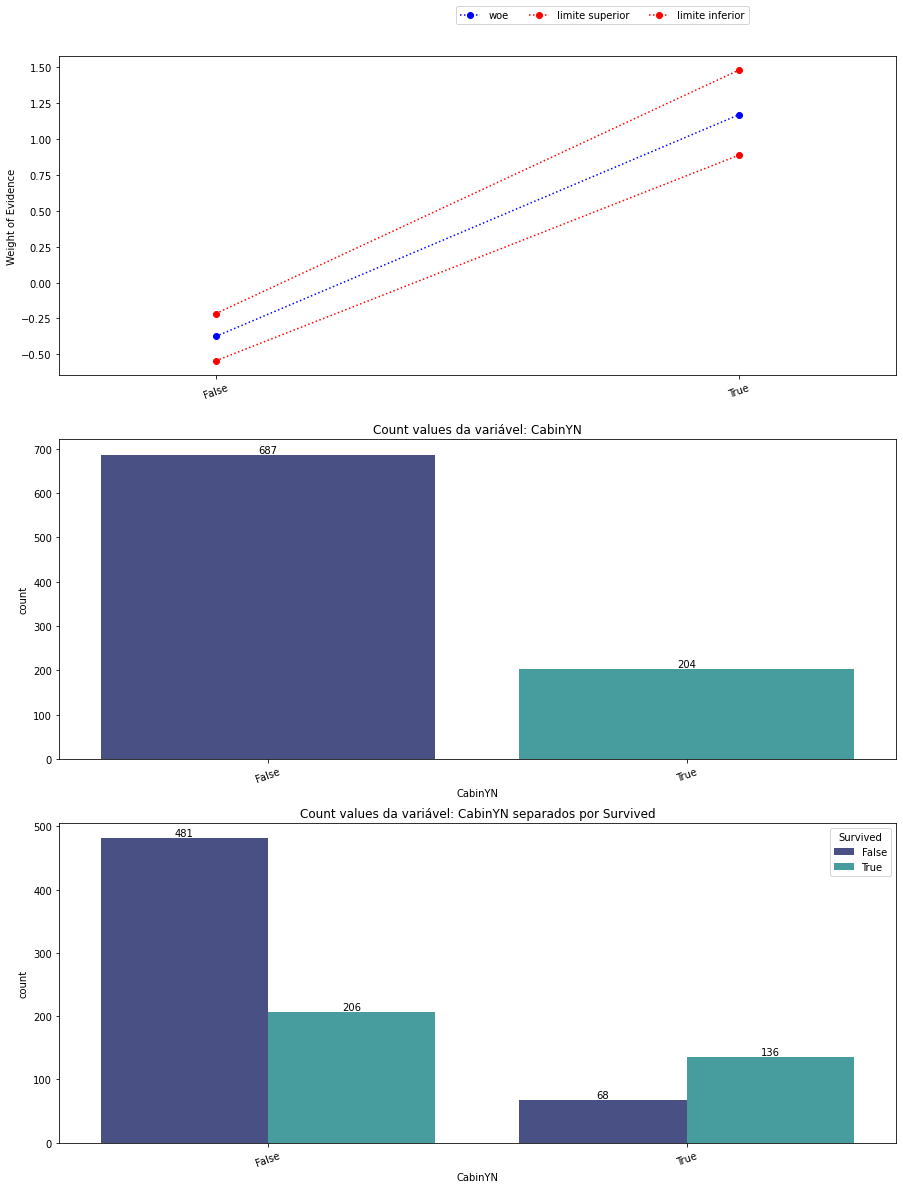

In [114]:
biv_discreta(var='CabinYN', df=df_train)

##Embarked

Aqui só tratar os nulos:

In [115]:
df_train.replace({'nan': df_train['Embarked'].mode()[0]},inplace=True)
df['Embarked'].fillna(df_train['Embarked'].mode()[0], inplace = True)

df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

#Bônus: Regressão para determinação das idades missing:

##Preparação da base de dados:

Vamos unir nossos datasets de treino e teste em um único grupo, mas apenas com os valores que temos originalmente de idade para criarmos um modelo de regressão para previsão da idade:

In [116]:
df_reg = []

df_reg = df.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [117]:
df_reg.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_cat,Fsize,CabinYN
0,3,male,22.0,One,Zero,7.2500,S,Mr,Two,False
1,1,female,38.0,One,Zero,71.2833,C,Mrs,Two,True


In [118]:
df_reg['Age'].isnull().value_counts()

False    1046
True      263
Name: Age, dtype: int64

In [119]:
df_reg_train = df_reg.dropna()

In [120]:
X_reg_train_raw = df_reg_train.drop(columns = ['Age'], axis=1)
y_reg_train = df_reg_train['Age']

In [121]:
colunas_categoricas = ['Pclass', 'Sex', 'SibSp', 'Fsize', 'Parch', 'Embarked', 'Name_cat', 'CabinYN']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'),
    colunas_categoricas),
    remainder='passthrough')

In [122]:
X_reg_train = one_hot_enc.fit_transform(X_reg_train_raw)
X_reg_train = pd.DataFrame(X_reg_train, columns=one_hot_enc.get_feature_names_out(X_reg_train_raw.columns))

In [123]:
X_reg_train.columns

Index(['onehotencoder__Pclass_1', 'onehotencoder__Pclass_2',
       'onehotencoder__Pclass_3', 'onehotencoder__Sex_female',
       'onehotencoder__Sex_male', 'onehotencoder__SibSp_One',
       'onehotencoder__SibSp_Two or more', 'onehotencoder__SibSp_Zero',
       'onehotencoder__Fsize_Five or more', 'onehotencoder__Fsize_Four',
       'onehotencoder__Fsize_One', 'onehotencoder__Fsize_Three',
       'onehotencoder__Fsize_Two', 'onehotencoder__Parch_One',
       'onehotencoder__Parch_Three or more', 'onehotencoder__Parch_Two',
       'onehotencoder__Parch_Zero', 'onehotencoder__Embarked_C',
       'onehotencoder__Embarked_Q', 'onehotencoder__Embarked_S',
       'onehotencoder__Name_cat_Master', 'onehotencoder__Name_cat_Miss',
       'onehotencoder__Name_cat_Mr', 'onehotencoder__Name_cat_Mrs',
       'onehotencoder__Name_cat_Officer', 'onehotencoder__Name_cat_Royal',
       'onehotencoder__CabinYN_False', 'onehotencoder__CabinYN_True',
       'remainder__Fare'],
      dtype='object')

##Escolhendo o tipo de modelo:

In [124]:
from pycaret.regression import *

In [125]:
%%time

exp_reg_age = setup(data = df_reg_train, 
                    target = 'Age', 
                    session_id=123,
                    remove_multicollinearity = True, multicollinearity_threshold = 0.90)
  
best_model = compare_models(fold=5)

,Description,Value
0,Session id,123
1,Target,Age
2,Target type,Regression
3,Data shape,"(1046, 28)"
4,Train data shape,"(732, 28)"
5,Test data shape,"(314, 28)"
6,Ordinal features,2
7,Numeric features,1
8,Categorical features,8
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,8.4871,122.0783,11.0343,0.3949,0.4565,0.6951,0.1560
ridge,Ridge Regression,8.6571,122.9815,11.0799,0.3940,0.4802,0.7218,0.1000
br,Bayesian Ridge,8.6580,123.1441,11.0880,0.3939,0.4754,0.7403,0.0960
lr,Linear Regression,8.6811,123.5374,11.1043,0.3907,0.4869,0.7185,1.3300
huber,Huber Regressor,8.6272,125.9316,11.2085,0.3815,0.4833,0.7064,0.1280
lightgbm,Light Gradient Boosting Machine,8.6070,125.6101,11.1918,0.3770,0.4633,0.6185,0.2680
lar,Least Angle Regression,8.8297,126.9552,11.2592,0.3753,0.4908,0.7578,0.1060
ada,AdaBoost Regressor,9.3040,132.6164,11.5054,0.3456,0.4943,0.8422,0.1180
rf,Random Forest Regressor,8.8977,133.7266,11.5430,0.3356,0.4719,0.6098,0.3220
et,Extra Trees Regressor,9.5743,158.7282,12.5830,0.2092,0.5129,0.5840,0.2820


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

CPU times: user 13 s, sys: 426 ms, total: 13.4 s
Wall time: 30.9 s


Vamos utilizar o Gradient Boosting Regressor.

##Modelagem:

In [126]:
reg = GradientBoostingRegressor()

In [127]:
reg.fit(X_reg_train, y_reg_train)

GradientBoostingRegressor()

In [128]:
reg.score(X_reg_train, y_reg_train)

0.5861835626588017

Comparação gráfica das idades se inseridas a partir do modelo criado:

In [129]:
colunas_categoricas = ['Pclass', 'Sex', 'SibSp', 'Fsize', 'Parch', 'Embarked', 'Name_cat', 'CabinYN']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'),
    colunas_categoricas),
    remainder='passthrough')

In [130]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Died', 'Name_cat',
       'Age_Cat', 'Fsize', 'Fare_Cat', 'CabinYN'],
      dtype='object')

In [131]:
df_train_cut = df_train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Died', 'Survived', 'Age_Cat', 'Age', 'Fare_Cat'])
data_unseen_cut = data_unseen.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived', 'Age_Cat', 'Age', 'Fare_Cat'])

In [132]:
df_train_dummies = one_hot_enc.fit_transform(df_train_cut)
df_train_dummies = pd.DataFrame(df_train_dummies, columns=one_hot_enc.get_feature_names_out(df_train_cut.columns))

data_unseen_dummies = one_hot_enc.fit_transform(data_unseen_cut)
data_unseen_dummies = pd.DataFrame(data_unseen_dummies, columns=one_hot_enc.get_feature_names_out(data_unseen_cut.columns))
data_unseen_dummies['onehotencoder__Name_cat_Royal'] = 0

df_train_dummies.columns

Index(['onehotencoder__Pclass_1', 'onehotencoder__Pclass_2',
       'onehotencoder__Pclass_3', 'onehotencoder__Sex_female',
       'onehotencoder__Sex_male', 'onehotencoder__SibSp_One',
       'onehotencoder__SibSp_Two or more', 'onehotencoder__SibSp_Zero',
       'onehotencoder__Fsize_Five or more', 'onehotencoder__Fsize_Four',
       'onehotencoder__Fsize_One', 'onehotencoder__Fsize_Three',
       'onehotencoder__Fsize_Two', 'onehotencoder__Parch_One',
       'onehotencoder__Parch_Three or more', 'onehotencoder__Parch_Two',
       'onehotencoder__Parch_Zero', 'onehotencoder__Embarked_C',
       'onehotencoder__Embarked_Q', 'onehotencoder__Embarked_S',
       'onehotencoder__Name_cat_Master', 'onehotencoder__Name_cat_Miss',
       'onehotencoder__Name_cat_Mr', 'onehotencoder__Name_cat_Mrs',
       'onehotencoder__Name_cat_Officer', 'onehotencoder__Name_cat_Royal',
       'onehotencoder__CabinYN_False', 'onehotencoder__CabinYN_True',
       'remainder__Fare'],
      dtype='object')

In [133]:
y_pred = reg.predict(df_train_dummies)
y_test_pred = reg.predict(data_unseen_dummies)

In [134]:
df_train_dummies['Age'] = y_pred
data_unseen_dummies['Age'] = y_test_pred

In [135]:
df_4.loc[df_4.Age.isnull(), 'Age'] = df_train_dummies['Age']
df_5.loc[df_5.Age.isnull(), 'Age'] = data_unseen_dummies['Age']

In [136]:
df_4['Age'].isnull().value_counts()

False    891
Name: Age, dtype: int64

Text(0.5, 1.0, 'Quantidade de passageiros por idade')

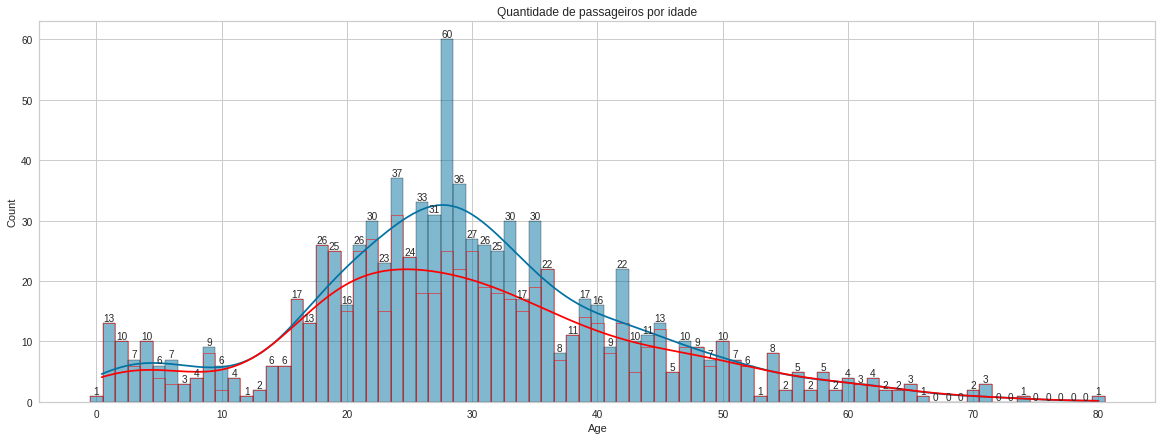

In [137]:
fig, ax = plt.subplots(figsize=(20,7))

sns.histplot(data=df_4, x='Age',discrete=True ,binrange=(0,80) ,kde=True, palette='mako', ax=ax)
sns.histplot(data=df_2, x='Age',discrete=True ,binrange=(0,80) ,kde=True, palette='mako', color='red', ax=ax, fill=False)
ax.bar_label(ax.containers[0])
ax.set_title('Quantidade de passageiros por idade')

##Normalidade das Idades encontradas:

In [138]:
# Idade inicial

stat, p_value = shapiro(x = df_2['Age'].dropna())
print(f"shapiro: statistic={stat:.4f}, p-value={p_value:.4f}")

shapiro: statistic=0.9815, p-value=0.0000


In [139]:
# Idade encontrada apenas pela média das idades

stat, p_value = shapiro(x = df_3['Age'])
print(f"shapiro: statistic={stat:.4f}, p-value={p_value:.4f}")

shapiro: statistic=0.9588, p-value=0.0000


In [140]:
# Idade encontrada pela média das idades nos grupos criados a partir dos nomes

stat, p_value = shapiro(x = df_train['Age'])
print(f"shapiro: statistic={stat:.4f}, p-value={p_value:.4f}")

shapiro: statistic=0.9740, p-value=0.0000


In [141]:
# Idade encontrada pelo modelo de regressão criado a partir da base de dados

stat, p_value = shapiro(x = df_4['Age'])
print(f"shapiro: statistic={stat:.4f}, p-value={p_value:.4f}")

shapiro: statistic=0.9797, p-value=0.0000


<font color='darkblue'>Temos que em todas as tentativas o p-value não indica normalidade, mas entre os 3 métodos de substituição das idades, a modelagem resultou no maior valor no teste Shapiro.</font>

##t-test

In [142]:
# Idade encontrada apenas pela média das idades

stat, p_value = ttest_ind(df_3['Age'], df_2['Age'].dropna())
print(f"t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

t-test: statistic=0.0000, p-value=1.0000


In [143]:
# Idade encontrada pela média das idades nos grupos criados a partir dos nomes

stat, p_value = ttest_ind(df_train['Age'], df_2['Age'].dropna())
print(f"t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

t-test: statistic=0.0762, p-value=0.9393


In [144]:
# Idade encontrada pelo modelo de regressão criado a partir da base de dados

stat, p_value = ttest_ind(df_4['Age'], df_2['Age'].dropna())
print(f"t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

t-test: statistic=-0.1241, p-value=0.9012


<font color='darkblue'>As idades encontradas via modelagem foram as que mais distanciaram da média de valores das idades já existentes.</font>

##Conclusão:

Iremos utilizar as idades encontradas pela modelagem.

In [145]:
df_train['Age'] = df_4['Age']
data_unseen['Age'] = df_5['Age']

#Resumo alterações

In [146]:
metadados = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados['nmissing'] = df_train.isna().sum()
metadados['valores_unicos'] = df_train.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['Survived','papel'] = 'resposta'
metadados.drop(index=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Died'], inplace=True)
metadados

,dtype,nmissing,valores_unicos,papel
Survived,bool,0,2,resposta
Pclass,object,0,3,covariavel
Sex,object,0,2,covariavel
Age,float64,0,172,covariavel
SibSp,object,0,3,covariavel
Parch,object,0,4,covariavel
Fare,float64,0,248,covariavel
Embarked,object,0,3,covariavel
Name_cat,object,0,6,covariavel
Age_Cat,object,0,18,covariavel


#Seleção de variáveis para o modelo

Como uma regressão logistica pode ser uma opção irei calcular os IVs das variáveis para vermos se conseguimos alguma informação extra:

Calculo do IV:

In [147]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>20):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_train[var],20,duplicates='drop'), df_train.Survived)
    else: 
        metadados.loc[var, 'IV'] = IV(df_train[var], df_train.Survived)
    
metadados

,dtype,nmissing,valores_unicos,papel,IV
Survived,bool,0,2,resposta,NaN
Pclass,object,0,3,covariavel,0.500950
Sex,object,0,2,covariavel,1.341681
Age,float64,0,172,covariavel,0.284814
SibSp,object,0,3,covariavel,0.132211
Parch,object,0,4,covariavel,0.111172
Fare,float64,0,248,covariavel,0.690967
Embarked,object,0,3,covariavel,0.119923
Name_cat,object,0,6,covariavel,1.497212
Age_Cat,object,0,18,covariavel,0.345972


Utilizando a classificação de Siddiqi (2006) obtemos as seguintes classificações para nossas variáveis:

Not useful for prediction (Less than 0.02): Nenhuma <br>
Weak predictive Power (0.02 to 0.1): Nenhuma<br>
Medium predictive Power (0.1 to 0.3): *SibSp*, *Parch*, *Embarked*, *Age*.<br>
Strong predictive Power (0.3 to 0.5): *Age_Cat*, *Fsize*, *CabinYN*<br>
Suspicious Predictive Power (>0.5): *Pclass*, *Sex*, *Fare*, *Fare_Cat*, *Name_cat*

<font color='darkblue'>Agora precisamos testar se as variáveis são boas para o modelo.</font>

#Escolha do tipo de modelagem:

Primeiro aqui separaremos 2 dataset um com valores categóricos de Age e Fare e outro com os valores originais, também avaliaremos quais são as variáveis mais importantes em 3 dos melhores modelos propostos.

Retirando colunas do Dataframe que não são interessantes para uma modelagem:

In [148]:
from pycaret.classification import *

In [149]:
data1 = df_train.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Died', 'Age', 'Fare'], axis=1)
data2 = df_train.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Died', 'Age_Cat', 'Fare_Cat'], axis=1)
data2_test = data_unseen.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Age_Cat', 'Fare_Cat'], axis=1)

In [150]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    bool   
 1   Pclass    891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    object 
 5   Parch     891 non-null    object 
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
 8   Name_cat  891 non-null    object 
 9   Fsize     891 non-null    object 
 10  CabinYN   891 non-null    object 
dtypes: bool(1), float64(2), object(8)
memory usage: 70.6+ KB


In [151]:
data2_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    object 
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    object 
 4   Parch     418 non-null    object 
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
 7   Survived  418 non-null    bool   
 8   Name_cat  418 non-null    object 
 9   Fsize     418 non-null    object 
 10  CabinYN   418 non-null    object 
dtypes: bool(1), float64(2), object(8)
memory usage: 52.5+ KB


##data1

In [152]:
data1.head(2)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Name_cat,Age_Cat,Fsize,Fare_Cat,CabinYN
0,False,3,male,One,Zero,S,Mr,"(21.79, 22.0]",Two,"(7.225, 7.55]",False
1,True,1,female,One,Zero,C,Mrs,"(35.72, 38.0]",Two,"(56.496, 77.958]",True


In [153]:
%%time

exp_clf1 = setup(data = data1, 
                target = 'Survived', 
                session_id=123,
                normalize = True, 
                transformation = True, 
                remove_multicollinearity = True, multicollinearity_threshold = 0.90)

best_model = compare_models(fold=5, sort='Accuracy')

,Description,Value
0,Session id,123
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 11)"
4,Transformed data shape,"(891, 65)"
5,Transformed train set shape,"(623, 65)"
6,Transformed test set shape,"(268, 65)"
7,Ordinal features,2
8,Categorical features,10
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8395,0.8696,0.7451,0.8215,0.7803,0.6545,0.6575,0.3600
gbc,Gradient Boosting Classifier,0.8379,0.8721,0.7535,0.8144,0.7810,0.6528,0.6559,0.2520
et,Extra Trees Classifier,0.8363,0.8511,0.7493,0.8123,0.7786,0.6491,0.6515,0.3360
dt,Decision Tree Classifier,0.8138,0.7999,0.7490,0.7640,0.7558,0.6055,0.6062,0.1740
ridge,Ridge Classifier,0.8138,0.0000,0.7242,0.7788,0.7488,0.6015,0.6042,0.1260
lda,Linear Discriminant Analysis,0.8138,0.8630,0.7242,0.7788,0.7488,0.6015,0.6042,0.3440
lr,Logistic Regression,0.8106,0.8480,0.7074,0.7830,0.7408,0.5925,0.5967,1.8260
ada,Ada Boost Classifier,0.8058,0.8425,0.7157,0.7665,0.7389,0.5846,0.5869,0.2580
knn,K Neighbors Classifier,0.7529,0.7966,0.6156,0.7096,0.6533,0.4640,0.4714,0.1840
svm,SVM - Linear Kernel,0.7352,0.0000,0.6193,0.6685,0.6402,0.4318,0.4349,0.1320


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

CPU times: user 12.5 s, sys: 214 ms, total: 12.7 s
Wall time: 36 s


##data2

In [154]:
data2.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_cat,Fsize,CabinYN
0,False,3,male,22.0,One,Zero,7.2500,S,Mr,Two,False
1,True,1,female,38.0,One,Zero,71.2833,C,Mrs,Two,True


In [155]:
%%time

exp_clf2 = setup(data = data2, 
                target = 'Survived', 
                session_id=123,
                normalize = True, 
                transformation = True, 
                remove_multicollinearity = True, multicollinearity_threshold = 0.90)

best_model = compare_models(fold=5, sort='Accuracy')

,Description,Value
0,Session id,123
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 11)"
4,Transformed data shape,"(891, 29)"
5,Transformed train set shape,"(623, 29)"
6,Transformed test set shape,"(268, 29)"
7,Ordinal features,2
8,Numeric features,2
9,Categorical features,8


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8427,0.8640,0.7492,0.8259,0.7843,0.6612,0.6644,0.2340
lr,Logistic Regression,0.8298,0.8681,0.7574,0.7916,0.7736,0.6374,0.6384,0.9420
ridge,Ridge Classifier,0.8250,0.0000,0.7365,0.7935,0.7637,0.6251,0.6265,0.1100
lda,Linear Discriminant Analysis,0.8250,0.8764,0.7365,0.7935,0.7637,0.6251,0.6265,0.1500
lightgbm,Light Gradient Boosting Machine,0.8218,0.8617,0.7409,0.7866,0.7599,0.6189,0.6226,0.1780
ada,Ada Boost Classifier,0.8202,0.8515,0.7617,0.7682,0.7643,0.6191,0.6198,0.2240
rf,Random Forest Classifier,0.8170,0.8633,0.7324,0.7805,0.7541,0.6088,0.6110,0.3240
et,Extra Trees Classifier,0.7994,0.8447,0.7408,0.7403,0.7381,0.5759,0.5782,0.2960
svm,SVM - Linear Kernel,0.7849,0.0000,0.7618,0.7030,0.7310,0.5523,0.5538,0.1080
knn,K Neighbors Classifier,0.7833,0.8330,0.6490,0.7576,0.6915,0.5278,0.5371,0.1620


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

CPU times: user 9.5 s, sys: 155 ms, total: 9.65 s
Wall time: 25.6 s


<font color='darkblue'>Concluimos que criar categorias para as variáveis *Age* e *Fare* acabou não sendo muito efetivo. Vamos então utilizar o Gradient Boosting Classifier no nosso data2.</font>

#Modelagem

##Preparação das bases de treino:

Criação de Dummies:

In [156]:
colunas_categoricas = ['Pclass', 'Sex', 'SibSp', 'Fsize', 'Parch', 'Embarked', 'Name_cat', 'CabinYN']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'),
    colunas_categoricas),
    remainder='passthrough')

In [157]:
data = one_hot_enc.fit_transform(data2)
data = pd.DataFrame(data, columns=one_hot_enc.get_feature_names_out(data2.columns))

data.columns

Index(['onehotencoder__Pclass_1', 'onehotencoder__Pclass_2',
       'onehotencoder__Pclass_3', 'onehotencoder__Sex_female',
       'onehotencoder__Sex_male', 'onehotencoder__SibSp_One',
       'onehotencoder__SibSp_Two or more', 'onehotencoder__SibSp_Zero',
       'onehotencoder__Fsize_Five or more', 'onehotencoder__Fsize_Four',
       'onehotencoder__Fsize_One', 'onehotencoder__Fsize_Three',
       'onehotencoder__Fsize_Two', 'onehotencoder__Parch_One',
       'onehotencoder__Parch_Three or more', 'onehotencoder__Parch_Two',
       'onehotencoder__Parch_Zero', 'onehotencoder__Embarked_C',
       'onehotencoder__Embarked_Q', 'onehotencoder__Embarked_S',
       'onehotencoder__Name_cat_Master', 'onehotencoder__Name_cat_Miss',
       'onehotencoder__Name_cat_Mr', 'onehotencoder__Name_cat_Mrs',
       'onehotencoder__Name_cat_Officer', 'onehotencoder__Name_cat_Royal',
       'onehotencoder__CabinYN_False', 'onehotencoder__CabinYN_True',
       'remainder__Survived', 'remainder__Age', 'rem

In [158]:
data_test = one_hot_enc.fit_transform(data2_test)
data_test = pd.DataFrame(data_test, columns=one_hot_enc.get_feature_names_out(data2_test.columns))
data_test['onehotencoder__Name_cat_Royal'] = 0

data_test.columns

Index(['onehotencoder__Pclass_1', 'onehotencoder__Pclass_2',
       'onehotencoder__Pclass_3', 'onehotencoder__Sex_female',
       'onehotencoder__Sex_male', 'onehotencoder__SibSp_One',
       'onehotencoder__SibSp_Two or more', 'onehotencoder__SibSp_Zero',
       'onehotencoder__Fsize_Five or more', 'onehotencoder__Fsize_Four',
       'onehotencoder__Fsize_One', 'onehotencoder__Fsize_Three',
       'onehotencoder__Fsize_Two', 'onehotencoder__Parch_One',
       'onehotencoder__Parch_Three or more', 'onehotencoder__Parch_Two',
       'onehotencoder__Parch_Zero', 'onehotencoder__Embarked_C',
       'onehotencoder__Embarked_Q', 'onehotencoder__Embarked_S',
       'onehotencoder__Name_cat_Master', 'onehotencoder__Name_cat_Miss',
       'onehotencoder__Name_cat_Mr', 'onehotencoder__Name_cat_Mrs',
       'onehotencoder__Name_cat_Officer', 'onehotencoder__CabinYN_False',
       'onehotencoder__CabinYN_True', 'remainder__Age', 'remainder__Fare',
       'remainder__Survived', 'onehotencoder__Na

In [229]:
X_train = data.drop(columns = ['remainder__Survived'], axis=1)
X_test = data_test.drop(columns = ['remainder__Survived'], axis=1)
y_train = data2['Survived']
y_test = data2_test['Survived']

Gradient Boosting Classifier:

In [160]:
clf1 = GradientBoostingClassifier(n_estimators=50, learning_rate=1,
      max_depth=1, random_state=123).fit(X_train, y_train)

In [161]:
clf1.score(X_train, y_train)

0.8540965207631874

In [162]:
clf1.score(X_test, y_test)

0.9186602870813397

Verificar as 5 melhores variáveis:

In [163]:
importancia = pd.Series(clf1.feature_importances_, index = X_train.columns)
importancia.sort_values(ascending = False, inplace = True)
importancia.head(5)

onehotencoder__Sex_female            0.597104
onehotencoder__Pclass_3              0.122925
onehotencoder__Fsize_Five or more    0.089493
onehotencoder__Name_cat_Master       0.062425
remainder__Fare                      0.049488
dtype: float64

Criar um modelo com as 5 variáveis de maior importância:

In [230]:
X_train_cut = X_train[['onehotencoder__Sex_female', 'onehotencoder__Pclass_3',
                      'onehotencoder__Fsize_Five or more', 'onehotencoder__Name_cat_Master',
                      'remainder__Fare']]

X_test_cut = X_test[['onehotencoder__Sex_female', 'onehotencoder__Pclass_3',
                      'onehotencoder__Fsize_Five or more', 'onehotencoder__Name_cat_Master',
                      'remainder__Fare']]

In [165]:
clf2 = GradientBoostingClassifier(n_estimators=50, learning_rate=1,
      max_depth=1, random_state=123).fit(X_train_cut, y_train)

In [166]:
clf2.score(X_train_cut, y_train)

0.8473625140291807

In [167]:
clf2.score(X_test_cut, y_test)

0.930622009569378

##Melhorar os parâmetros do modelo:

###learning_rate:

In [168]:
parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 1],
    }

In [169]:
clf3 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1)

In [170]:
%%time

clf3.fit(X_train_cut, y_train)
print(clf3.score(X_train_cut, y_train))
print(clf3.best_params_)

0.8731762065095399
{'learning_rate': 0.075}
CPU times: user 228 ms, sys: 8.3 ms, total: 236 ms
Wall time: 4.61 s


In [171]:
learning_rate = clf3.best_params_['learning_rate']
learning_rate

0.075

###min_samples_split:

In [172]:
parameters = {
    "learning_rate": [learning_rate],
    "min_samples_split": np.linspace(start=2, stop=50, num=49, dtype=int),
    }

In [173]:
clf3 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1)

In [174]:
%%time

clf3.fit(X_train_cut, y_train)
print(clf3.score(X_train_cut, y_train))
print(clf3.best_params_)

0.8731762065095399
{'learning_rate': 0.075, 'min_samples_split': 28}
CPU times: user 795 ms, sys: 29.2 ms, total: 824 ms
Wall time: 15.9 s


In [175]:
min_samples_split = clf3.best_params_['min_samples_split']
min_samples_split

28

###min_samples_leaf:

In [176]:
parameters = {
    "learning_rate": [learning_rate],
    "min_samples_split": [min_samples_split],
    "min_samples_leaf": np.linspace(start=1, stop=50, num=50, dtype=int),
    }

In [177]:
clf3 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1)

In [178]:
%%time

clf3.fit(X_train_cut, y_train)
print(clf3.score(X_train_cut, y_train))
print(clf3.best_params_)

0.8653198653198653
{'learning_rate': 0.075, 'min_samples_leaf': 17, 'min_samples_split': 28}
CPU times: user 803 ms, sys: 24.5 ms, total: 828 ms
Wall time: 15.6 s


In [179]:
min_samples_leaf = clf3.best_params_['min_samples_leaf']
min_samples_leaf

17

###max_depth:

In [180]:
parameters = {
    "learning_rate": [learning_rate],
    "min_samples_split": [min_samples_split],
    "min_samples_leaf": [min_samples_leaf],
    "max_depth":[2,3,4,5,6,7,8],
    }

In [181]:
clf3 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1)

In [182]:
%%time

clf3.fit(X_train_cut, y_train)
print(clf3.score(X_train_cut, y_train))
print(clf3.best_params_)

0.877665544332211
{'learning_rate': 0.075, 'max_depth': 7, 'min_samples_leaf': 17, 'min_samples_split': 28}
CPU times: user 268 ms, sys: 8.09 ms, total: 276 ms
Wall time: 3.05 s


In [183]:
max_depth = clf3.best_params_['max_depth']
max_depth

7

###subsample:

In [184]:
parameters = {
    "learning_rate": [learning_rate],
    "min_samples_split": [min_samples_split],
    "min_samples_leaf": [min_samples_leaf],
    "max_depth":[max_depth],
    "subsample":np.linspace(start=0.5, stop=1, num=51),
    }

In [185]:
clf3 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1)

In [186]:
%%time

clf3.fit(X_train_cut, y_train)
print(clf3.score(X_train_cut, y_train))
print(clf3.best_params_)

0.8821548821548821
{'learning_rate': 0.075, 'max_depth': 7, 'min_samples_leaf': 17, 'min_samples_split': 28, 'subsample': 0.9199999999999999}
CPU times: user 948 ms, sys: 46.2 ms, total: 994 ms
Wall time: 26.7 s


In [187]:
subsample = clf3.best_params_['subsample']
subsample

0.9199999999999999

###n_estimators:

In [188]:
parameters = {
    "learning_rate": [learning_rate],
    "min_samples_split": [min_samples_split],
    "min_samples_leaf": [min_samples_leaf],
    "max_depth":[max_depth],
    "subsample":[subsample],
    "n_estimators":np.linspace(start=51, stop=150, num=100, dtype=int)
    }

In [189]:
clf3 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1)

In [190]:
%%time

clf3.fit(X_train_cut, y_train)
print(clf3.score(X_train_cut, y_train))
print(clf3.best_params_)

0.8832772166105499
{'learning_rate': 0.075, 'max_depth': 7, 'min_samples_leaf': 17, 'min_samples_split': 28, 'n_estimators': 117, 'subsample': 0.9199999999999999}
CPU times: user 1.71 s, sys: 84.2 ms, total: 1.79 s
Wall time: 55.3 s


In [191]:
n_estimators = clf3.best_params_['n_estimators']
n_estimators

117

###Geral:

1:

In [192]:
parameters = {
    "learning_rate": [learning_rate-0.02,learning_rate,learning_rate+0.02],
    "min_samples_split": [min_samples_split,min_samples_split-5,min_samples_split-10],
    "min_samples_leaf": [min_samples_leaf],
    "max_depth":[max_depth,max_depth+1,max_depth+2],
    "subsample":[subsample,subsample-0.05,subsample-0.1,subsample-0.15],
    "n_estimators":[n_estimators-20,n_estimators-10,n_estimators,n_estimators+10,n_estimators+20]
    }

In [193]:
clf3 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1)

In [194]:
%%time

clf3.fit(X_train_cut, y_train)
print(clf3.score(X_train_cut, y_train))
print(clf3.best_params_)

0.8877665544332211
{'learning_rate': 0.095, 'max_depth': 8, 'min_samples_leaf': 17, 'min_samples_split': 28, 'n_estimators': 117, 'subsample': 0.7699999999999999}
CPU times: user 13.9 s, sys: 582 ms, total: 14.5 s
Wall time: 6min 14s


In [195]:
learning_rate = clf3.best_params_['learning_rate']
min_samples_split = clf3.best_params_['min_samples_split']
min_samples_leaf = clf3.best_params_['min_samples_leaf']
max_depth = clf3.best_params_['max_depth']
subsample = clf3.best_params_['subsample']
n_estimators = clf3.best_params_['n_estimators']

2:

In [196]:
parameters = {
    "learning_rate": [learning_rate-0.01,learning_rate,learning_rate+0.01],
    "min_samples_split": [min_samples_split],
    "min_samples_leaf": [min_samples_leaf],
    "max_depth":[max_depth],
    "subsample":[subsample,subsample-0.02,subsample-0.04,subsample-0.06,subsample-0.08],
    "n_estimators":[n_estimators-2,n_estimators,n_estimators+2]
    }

In [197]:
clf3 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1)

In [198]:
%%time

clf3.fit(X_train_cut, y_train)
print(clf3.score(X_train_cut, y_train))
print(clf3.best_params_)

0.8877665544332211
{'learning_rate': 0.085, 'max_depth': 8, 'min_samples_leaf': 17, 'min_samples_split': 28, 'n_estimators': 117, 'subsample': 0.7499999999999999}
CPU times: user 1.32 s, sys: 56.1 ms, total: 1.38 s
Wall time: 29.3 s


In [199]:
learning_rate = clf3.best_params_['learning_rate']
min_samples_split = clf3.best_params_['min_samples_split']
min_samples_leaf = clf3.best_params_['min_samples_leaf']
max_depth = clf3.best_params_['max_depth']
subsample = clf3.best_params_['subsample']
n_estimators = clf3.best_params_['n_estimators']

##Paramêtros finais:

In [200]:
parameters = {
    "learning_rate": [learning_rate],
    "min_samples_split": [min_samples_split],
    "min_samples_leaf": [min_samples_leaf],
    "max_depth":[max_depth],
    "subsample":[subsample],
    "n_estimators":[n_estimators]
    }

In [201]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1)

clf.fit(X_train_cut, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  random_state=None,
               

In [202]:
clf = GradientBoostingClassifier(n_estimators=n_estimators, 
                                 learning_rate=learning_rate,
                                 min_samples_split=min_samples_split, 
                                 min_samples_leaf=min_samples_leaf,
                                 subsample=subsample, 
                                 max_depth=max_depth, 
                                 random_state=123).fit(X_train_cut, y_train)

In [203]:
clf.score(X_train_cut, y_train)

0.8832772166105499

In [204]:
clf.score(X_test_cut, y_test)

0.8851674641148325

##Análise gráfica:

In [253]:
y = pd.DataFrame()
y2 = pd.DataFrame()
y['Survived'] = y_train
y2['Survived'] = y_test
y['Survived_pred'] = clf.predict(X_train_cut)
y2['Survived_pred'] = clf.predict(X_test_cut)
y.head()

,Survived,Survived_pred
0,False,False
1,True,True
2,True,True
3,True,True
4,False,False


###Base de treino

In [254]:
# Acurácia
acc = metrics.accuracy_score(y.Survived, y.Survived_pred)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(y.Survived, y.Survived_pred)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(y.loc[y.Survived == 1, 'Survived_pred'], y.loc[y.Survived != 1, 'Survived_pred']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 88.3% 
AUC: 87.1% 
GINI: 74.1%
KS: 74.1%


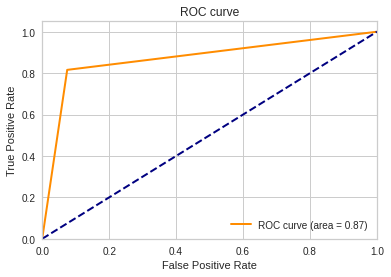

In [255]:
fpr, tpr, thresholds = metrics.roc_curve(y['Survived'], y['Survived_pred'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(y['Survived'], y['Survived_pred'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

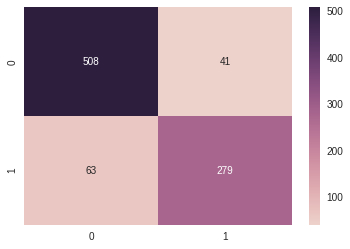

In [252]:
cm = confusion_matrix(y['Survived'], y['Survived_pred'])
sns.heatmap(cm, annot=True, fmt=".0f", cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

###Base de teste

In [256]:
# Acurácia
acc = metrics.accuracy_score(y2.Survived, y2.Survived_pred)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(y2.Survived, y2.Survived_pred)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(y2.loc[y2.Survived == 1, 'Survived_pred'], y2.loc[y2.Survived != 1, 'Survived_pred']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 88.5% 
AUC: 87.9% 
GINI: 75.8%
KS: 75.8%


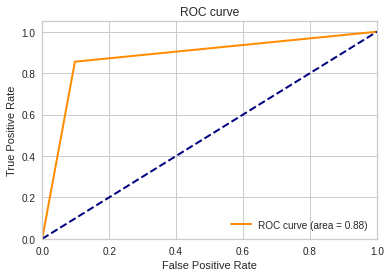

In [257]:
fpr, tpr, thresholds = metrics.roc_curve(y2['Survived'], y2['Survived_pred'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(y2['Survived'], y2['Survived_pred'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

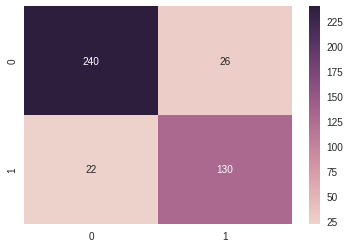

In [258]:
cm = confusion_matrix(y2['Survived'], y2['Survived_pred'])
sns.heatmap(cm, annot=True, fmt=".0f", cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()